In [1]:
import pandas as pd
from pandas import DataFrame, Series
#false positive warnings all the time:
pd.options.mode.chained_assignment = None

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import statistics

import os.path

In [2]:
#http://matplotlib.org/1.4.0/users/customizing.html

plt.style.use('ggplot')

mpl.rcParams['font.size'] = 18

### LINES
mpl.rcParams['lines.linewidth'] = '2.0'        # line width in points
mpl.rcParams['lines.marker']    = 'None'
mpl.rcParams['lines.markersize']=  '6'          # markersize, in points

###LEGEND
mpl.rcParams['legend.fontsize']='medium'

### GRIDS
mpl.rcParams['grid.color']='black'     # grid color
mpl.rcParams['grid.linestyle'] =':'    # dotted
mpl.rcParams['grid.linewidth']='0.5'   # in points
mpl.rcParams['grid.alpha']='1.0'       # transparency, between 0.0 and 1.0

### TICKS
mpl.rcParams['xtick.labelsize']="small"  # fontsize of the tick labels
mpl.rcParams['xtick.direction']="out"      # direction: in, out, or inout
mpl.rcParams['ytick.labelsize']="small"   # fontsize of the tick labels
mpl.rcParams['ytick.direction']="out"      # direction: in, out, or inout

### AXES
mpl.rcParams['axes.linewidth']  =  '1.0'    # edge linewidth
mpl.rcParams['axes.grid']       =  'True'   # display grid or not
mpl.rcParams['axes.titlesize']  =  'large'  # fontsize of the axes title
mpl.rcParams['axes.labelsize']  = 'large'  # fontsize of the x any y labels
mpl.rcParams['axes.facecolor']= 'white'     # axes background color

mpl.rcParams['figure.facecolor']= '1.0'     # figure facecolor; 0.75 is scalar gray

In [3]:
def generateSimulationID(tup):
    identifier = tup[0] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + tup[3] \
            + "_" + tup[4] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra


simulation_map = {
    "Watdiv10M": "W10", "Watdiv100M": "W100", "Watdiv1000M": "W1000", "Ontoforce": "Ont"
}

def generateSimulationIDCompact(tup, pref_length=3):
    #pref_length = 3
    identifier = tup[0][:pref_length] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + simulation_map[tup[3]] \
            + "_" + str(tup[4])[:pref_length] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra

In [4]:
def generateFilenameQueryEventsCorrect(bmtuple):
    fname = './csv_correct/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryevents_correct.csv"

# 1. Sort all query events 

* query order id (over all threads)
* query time offset
* query number of results generated offset

## Tryout

In [5]:
tuple_list = [('Blazegraph', 1, 64, 'Watdiv1000M', 'Optimized', ''), \
              ('ES', 1, 64, 'Watdiv1000M', 'Default', ''), \
              ('GraphDB', 1, 64, 'Watdiv1000M', 'Optimized', ''), \
              ('Virtuoso', 1, 64, 'Watdiv1000M', 'Optimized', ''), \

             ]

In [6]:
tup = tuple_list[3]
filename = generateFilenameQueryEventsCorrect(tup)
df = pd.read_csv(filename, sep='\t')
df.head(n=5)

sim_id            query_name  thread_id thread_type  order_id  \
0  Vir_N1_64_W1000_Opt  S5/S5_split14.sparql          1      warmup         1   
1  Vir_N1_64_W1000_Opt  S5/S5_split14.sparql         17      stress       326   
2  Vir_N1_64_W1000_Opt  S5/S5_split14.sparql         16      stress       134   
3  Vir_N1_64_W1000_Opt  S5/S5_split14.sparql         18      stress       214   
4  Vir_N1_64_W1000_Opt  S5/S5_split14.sparql         15      stress       135   

   number_of_results   runtime     flag  correct  
0                  0  0.873330  SUCCESS  CORRECT  
1                  0  0.072055  SUCCESS  CORRECT  
2                  0  0.044390  SUCCESS  CORRECT  
3                  0  0.073868  SUCCESS  CORRECT  
4                  0  0.075443  SUCCESS  CORRECT

In [7]:
all_threads = set(df['thread_id'].values)
all_threads

{1, 14, 15, 16, 17, 18}

In [8]:
df_t2 = df[df['thread_id'] == 14].sort_values('order_id') 
df_t2.head(n=5)

sim_id            query_name  thread_id thread_type  \
2207  Vir_N1_64_W1000_Opt   C1/C1_split1.sparql         14      stress   
2345  Vir_N1_64_W1000_Opt   S6/S6_split6.sparql         14      stress   
1661  Vir_N1_64_W1000_Opt  L1/L1_split15.sparql         14      stress   
2225  Vir_N1_64_W1000_Opt  F2/F2_split11.sparql         14      stress   
1619  Vir_N1_64_W1000_Opt   S4/S4_split3.sparql         14      stress   

      order_id  number_of_results    runtime     flag  correct  
2207         1               1424  47.518856  SUCCESS  CORRECT  
2345         2                 97   4.244986  SUCCESS  CORRECT  
1661         3                  7   0.005168  SUCCESS  CORRECT  
2225         4                399   4.631251  SUCCESS  CORRECT  
1619         5                 10   0.075722  SUCCESS  CORRECT

In [9]:
df_t2['cumul_time'] = df_t2['runtime'].cumsum()
df_t2.head(n=5)

sim_id            query_name  thread_id thread_type  \
2207  Vir_N1_64_W1000_Opt   C1/C1_split1.sparql         14      stress   
2345  Vir_N1_64_W1000_Opt   S6/S6_split6.sparql         14      stress   
1661  Vir_N1_64_W1000_Opt  L1/L1_split15.sparql         14      stress   
2225  Vir_N1_64_W1000_Opt  F2/F2_split11.sparql         14      stress   
1619  Vir_N1_64_W1000_Opt   S4/S4_split3.sparql         14      stress   

      order_id  number_of_results    runtime     flag  correct  cumul_time  
2207         1               1424  47.518856  SUCCESS  CORRECT   47.518856  
2345         2                 97   4.244986  SUCCESS  CORRECT   51.763842  
1661         3                  7   0.005168  SUCCESS  CORRECT   51.769010  
2225         4                399   4.631251  SUCCESS  CORRECT   56.400260  
1619         5                 10   0.075722  SUCCESS  CORRECT   56.475983

In [10]:
thread_groups = df.groupby('thread_id')

grps= []

for n, g in thread_groups:
    g_sorted = g.sort_values('order_id') 
    g_sorted['cumul_time'] = g_sorted['runtime'].cumsum()
    grps.append(g_sorted)

    
regrouped = pd.concat(grps)
mask = regrouped['thread_type'] == 'stress' 
regrouped_stress = regrouped[mask]
regrouped_stress

regrouped_warmup = regrouped[~mask]

In [11]:
regrouped_warmup
warmup_time_total = regrouped_warmup['cumul_time'].max()

regrouped_stress['cumul_time'] = regrouped_stress['cumul_time'] + warmup_time_total


In [12]:
regrouped_all = pd.concat([regrouped_warmup, regrouped_stress])

In [13]:
df_events_sorted  = regrouped_all.reset_index(drop=True).sort_values('cumul_time')

### Now we have the order of the queries as it happened during the benchmark

In [14]:
df_events_sorted[df_events_sorted['thread_type'] == 'stress'].head(n=10)

sim_id            query_name  thread_id thread_type  \
800   Vir_N1_64_W1000_Opt   S5/S5_split4.sparql         15      stress   
801   Vir_N1_64_W1000_Opt  S3/S3_split14.sparql         15      stress   
2000  Vir_N1_64_W1000_Opt  L5/L5_split18.sparql         18      stress   
2001  Vir_N1_64_W1000_Opt   L3/L3_split0.sparql         18      stress   
2002  Vir_N1_64_W1000_Opt   S4/S4_split8.sparql         18      stress   
1600  Vir_N1_64_W1000_Opt  S6/S6_split11.sparql         17      stress   
1601  Vir_N1_64_W1000_Opt   S2/S2_split6.sparql         17      stress   
1602  Vir_N1_64_W1000_Opt   S5/S5_split9.sparql         17      stress   
1603  Vir_N1_64_W1000_Opt   S2/S2_split3.sparql         17      stress   
1604  Vir_N1_64_W1000_Opt   F1/F1_split1.sparql         17      stress   

      order_id  number_of_results   runtime     flag  correct   cumul_time  
800          1                  0  0.062337  SUCCESS  CORRECT  1862.129789  
801          2                  0  0.044858  SUCCESS  CORRECT  1862.174648  
2000         1               1936  0.110460  SUCCESS  CORRECT  1862.177912  
2001         2                 43  0.005216  SUCCESS  CORRECT  1862.183128  
2002         3                 10  0.073133  SUCCESS  CORRECT  1862.256261  
1600         1                 42  3.236787  SUCCESS  CORRECT  1865.304239  
1601         2               3380  0.158073  SUCCESS  CORRECT  1865.462312  
1602         3                  0  0.118791  SUCCESS  CORRECT  1865.581103  
1603         4               1909  0.161205  SUCCESS  CORRECT  1865.742309  
1604         5                251  0.083877  SUCCESS  CORRECT  1865.826186

### reset the index => we have the order of the queries 'overall_order_id'

In [15]:
df_events_sorted.reset_index(drop=True, inplace=True)
df_events_sorted['overall_order_id'] = list(df_events_sorted.index)
df_events_sorted.tail(n=5)

sim_id            query_name  thread_id thread_type  \
2395  Vir_N1_64_W1000_Opt  F2/F2_split16.sparql         15      stress   
2396  Vir_N1_64_W1000_Opt  S7/S7_split15.sparql         15      stress   
2397  Vir_N1_64_W1000_Opt  F4/F4_split18.sparql         15      stress   
2398  Vir_N1_64_W1000_Opt   L5/L5_split4.sparql         15      stress   
2399  Vir_N1_64_W1000_Opt  F4/F4_split17.sparql         15      stress   

      order_id  number_of_results   runtime     flag  correct   cumul_time  \
2395       396                569  3.502915  SUCCESS  CORRECT  3900.380482   
2396       397                  2  0.003893  SUCCESS  CORRECT  3900.384375   
2397       398               3021  0.495305  SUCCESS  CORRECT  3900.879680   
2398       399               1739  0.112679  SUCCESS  CORRECT  3900.992359   
2399       400               2469  0.506463  SUCCESS  CORRECT  3901.498822   

      overall_order_id  
2395              2395  
2396              2396  
2397              2397  
2398              2398  
2399              2399

### add the cumulative number of results

In [16]:
df_events_sorted['cumul_results'] = df_events_sorted['number_of_results'].cumsum()

In [18]:
df_events_sorted.to_csv('query_events_sorted/'+generateSimulationID(tup)+"_events_sorted.csv", sep='\t')

### create sorted events frame in a function

In [19]:
def generate_sorted_events_filename(tup):
    return 'query_events_sorted/'+generateSimulationID(tup)+"_events_sorted.csv"

In [20]:
def create_sorted_events_frame(tup):
    filename = generateFilenameQueryEventsCorrect(tup)
    df = pd.read_csv(filename, sep='\t')
 
    thread_groups = df.groupby('thread_id')

    grps= []
    #create cumulative time per thread for global ordering of query events
    for n, g in thread_groups:
        g['temp_time'] = g['runtime'].apply(lambda t: t if t>=0 else 1e-6)
        
        g_sorted = g.sort_values('order_id')
        
        g_sorted['cumul_time'] = g_sorted['temp_time'].cumsum()
        
        g_sorted.drop('temp_time', axis=1, inplace=True)
        
        grps.append(g_sorted)


    regrouped = pd.concat(grps)
    mask = regrouped['thread_type'] == 'stress' 
    regrouped_stress = regrouped[mask]
    regrouped_warmup = regrouped[~mask]
    
    #add warmup offset to cumul_time
    warmup_time_total = regrouped_warmup['cumul_time'].max()
    regrouped_stress['cumul_time'] = regrouped_stress['cumul_time'] + warmup_time_total
    
    #combine results again
    regrouped_all = pd.concat([regrouped_warmup, regrouped_stress])
    
    #sort by cumul_time to get global ordering
    #
    df_events_sorted  = regrouped_all.reset_index(drop=True).sort_values('cumul_time')
    
    
    df_events_sorted.reset_index(drop=True, inplace=True)
    df_events_sorted['overall_order_id'] = list(df_events_sorted.index)
    
    #add cumul results
    df_events_sorted['temp_results'] =  df_events_sorted['number_of_results'].apply(lambda r: r if r>=0 else 0)
    
    df_events_sorted['cumul_results'] = df_events_sorted['temp_results'].cumsum()
    
    df_events_sorted.drop('temp_results', axis=1, inplace=True)
    
    df_events_sorted.to_csv(generate_sorted_events_filename(tup), sep='\t')

## A.  (NoSQL,1,32,Watdiv10M,Default)     => #query events = 3 x 2000 + 10 x 2000


In [21]:
tuple_list = [('Blazegraph', 1, 32,'Watdiv10M', 'Default', ''), \
    ('GraphDB', 1, 32,'Watdiv10M', 'Default', ''), \
    ('ES', 1, 32,'Watdiv10M', 'Default', ''), \
    ('Virtuoso', 1, 32,'Watdiv10M', 'Default', '')]  

for t in tuple_list:
    create_sorted_events_frame(t)


## B  (NoSQL,1,32,Watdiv100M,Default)    => #query events = 3 x 2000 + 10 x 2000


In [22]:
tuple_list = [('Blazegraph', 1, 32,'Watdiv100M', 'Default', ''), \
    ('GraphDB', 1, 32,'Watdiv100M', 'Default', ''), \
    #('ES', 1, 32,'Watdiv100M', 'Default', ''), \
    ('Virtuoso', 1, 32,'Watdiv100M', 'Default', '')]  

for t in tuple_list:
    create_sorted_events_frame(t)

## C.  (NoSQL,1,32,Watdiv1000M,Default)   => #query events = 1 x 2000 + 3 x 2000


In [23]:
tuple_list = [ \
                ('Blazegraph', 1, 32,'Watdiv1000M', 'Default', '')  , \
                #('GraphDB', 1, 32,'Watdiv1000M', 'Default', '')    , \
                ('ES', 1, 32,'Watdiv1000M', 'Default', '')          ,  \
                ('Virtuoso', 1, 32,'Watdiv1000M', 'Default', '')       \
          
             ]         
for t in tuple_list:
    create_sorted_events_frame(t)


## D1 (NoSQL,1,64,Watdiv1000M,Default)   => #query events = 1 x 400  + 5 x 400 
## D2 (NoSQL,1,64,Watdiv1000M,Optimized) => #query events = 1 x 400  + 5 x 400 
## D3 (Other,1,64,Watdiv1000M,Default)   => #query events = 1 x 400  + 5 x 400 

In [24]:
tuple_list = [ \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Default', '')  , \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Default', '')     , \
                ('ES', 1, 64,'Watdiv1000M', 'Default', '')          , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Default', '')    , \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Optimized', ''), \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Optimized', '')   , \
                #('ES', 1, 64,'Watdiv1000M', 'Optimized', '')       , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Optimized', '')  , \
                ('Fuseki', 1, 64,'Watdiv1000M', 'Default', '')      , \
                ('FluidOps', 3, 64,'Watdiv1000M', 'Default', '')    , \
                ('LDF', 1, 64,'Watdiv1000M', 'Default', '')         , \
                ('LDF', 3, 64,'Watdiv1000M', 'Default', '')           \
             ]


for t in tuple_list:
    create_sorted_events_frame(t)

## E (Other,1,64,Watdiv100M,Default)    => #query events = 1 x 400  + 5 x 400 


In [25]:
tuple_list = [('Fuseki', 1, 64,'Watdiv100M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv100M', 'Default', '')]  

for t in tuple_list:
    create_sorted_events_frame(t)

## Remainder:

* Ontoforce data

In [26]:
tuple_list = [('Virtuoso', 1, 32,'Ontoforce', 'Optimized', ''), \
    ('Virtuoso', 1, 32,'Ontoforce', 'Optimized', 'VWall'), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', 'VWall'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '0'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '1'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '2'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS1'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS2'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS3'), \
    ('Fuseki', 1, 64,'Ontoforce', 'Default', ''), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '1'), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '2'), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '3'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '1'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '2'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '3')]

for t in tuple_list:
    create_sorted_events_frame(t)

# 2. Offsets in terms of order

In [27]:
df = pd.read_csv(generate_sorted_events_filename(tup), sep='\t', index_col=0)
df.head(n=10)

sim_id            query_name  thread_id thread_type  order_id  \
0  Vir_N1_64_W1000_Opt  S5/S5_split14.sparql          1      warmup         1   
1  Vir_N1_64_W1000_Opt  L1/L1_split17.sparql          1      warmup         2   
2  Vir_N1_64_W1000_Opt  S1/S1_split12.sparql          1      warmup         3   
3  Vir_N1_64_W1000_Opt  S6/S6_split17.sparql          1      warmup         4   
4  Vir_N1_64_W1000_Opt   F1/F1_split2.sparql          1      warmup         5   
5  Vir_N1_64_W1000_Opt  F5/F5_split10.sparql          1      warmup         6   
6  Vir_N1_64_W1000_Opt  S3/S3_split14.sparql          1      warmup         7   
7  Vir_N1_64_W1000_Opt   S3/S3_split6.sparql          1      warmup         8   
8  Vir_N1_64_W1000_Opt   F5/F5_split6.sparql          1      warmup         9   
9  Vir_N1_64_W1000_Opt   F1/F1_split0.sparql          1      warmup        10   

   number_of_results   runtime     flag  correct  cumul_time  \
0                  0  0.873330  SUCCESS  CORRECT    0.873330   
1                  0  1.318553  SUCCESS  CORRECT    2.191883   
2                  9  5.462552  SUCCESS  CORRECT    7.654435   
3               1567  4.722458  SUCCESS  CORRECT   12.376893   
4                251  0.662693  SUCCESS  CORRECT   13.039586   
5                 43  0.544959  SUCCESS  CORRECT   13.584546   
6                  0  0.161130  SUCCESS  CORRECT   13.745676   
7                  0  0.056398  SUCCESS  CORRECT   13.802074   
8                 32  0.023044  SUCCESS  CORRECT   13.825117   
9                251  0.081548  SUCCESS  CORRECT   13.906666   

   overall_order_id  cumul_results  
0                 0              0  
1                 1              0  
2                 2              9  
3                 3           1576  
4                 4           1827  
5                 5           1870  
6                 6           1870  
7                 7           1870  
8                 8           1902  
9                 9           2153

In [28]:
grouped_per_query = df.groupby('query_name')

In [29]:
for n, g in grouped_per_query:
    print(n)
    break
g    

C1/C1_split0.sparql


sim_id           query_name  thread_id thread_type  \
79    Vir_N1_64_W1000_Opt  C1/C1_split0.sparql          1      warmup   
555   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         18      stress   
737   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         15      stress   
1389  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         17      stress   
1551  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         14      stress   
1865  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         16      stress   

      order_id  number_of_results    runtime     flag  correct   cumul_time  \
79          80               1424  53.092190  SUCCESS  CORRECT   308.729141   
555         17               1424  47.584711  SUCCESS  CORRECT  2010.974900   
737         94               1424  48.751925  SUCCESS  CORRECT  2168.474007   
1389       169               1424  49.794759  SUCCESS  CORRECT  2840.517663   
1551       207               1424  53.286911  SUCCESS  CORRECT  2999.078499   
1865       280               1424  48.074759  SUCCESS  CORRECT  3308.097372   

      overall_order_id  cumul_results  
79                  79        4314113  
555                555       29648924  
737                737       33195971  
1389              1389       68619001  
1551              1551       74280081  
1865              1865       92800077

In [30]:
g_cleaned = g.sort_values('cumul_time').reset_index()
g_cleaned

index               sim_id           query_name  thread_id thread_type  \
0     79  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql          1      warmup   
1    555  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         18      stress   
2    737  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         15      stress   
3   1389  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         17      stress   
4   1551  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         14      stress   
5   1865  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql         16      stress   

   order_id  number_of_results    runtime     flag  correct   cumul_time  \
0        80               1424  53.092190  SUCCESS  CORRECT   308.729141   
1        17               1424  47.584711  SUCCESS  CORRECT  2010.974900   
2        94               1424  48.751925  SUCCESS  CORRECT  2168.474007   
3       169               1424  49.794759  SUCCESS  CORRECT  2840.517663   
4       207               1424  53.286911  SUCCESS  CORRECT  2999.078499   
5       280               1424  48.074759  SUCCESS  CORRECT  3308.097372   

   overall_order_id  cumul_results  
0                79        4314113  
1               555       29648924  
2               737       33195971  
3              1389       68619001  
4              1551       74280081  
5              1865       92800077

In [31]:
g_previous = g_cleaned.shift(+1)
g_previous.dropna(inplace=True)
g_previous



index               sim_id           query_name  thread_id thread_type  \
1    79.0  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql        1.0      warmup   
2   555.0  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql       18.0      stress   
3   737.0  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql       15.0      stress   
4  1389.0  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql       17.0      stress   
5  1551.0  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql       14.0      stress   

   order_id  number_of_results    runtime     flag  correct   cumul_time  \
1      80.0             1424.0  53.092190  SUCCESS  CORRECT   308.729141   
2      17.0             1424.0  47.584711  SUCCESS  CORRECT  2010.974900   
3      94.0             1424.0  48.751925  SUCCESS  CORRECT  2168.474007   
4     169.0             1424.0  49.794759  SUCCESS  CORRECT  2840.517663   
5     207.0             1424.0  53.286911  SUCCESS  CORRECT  2999.078499   

   overall_order_id  cumul_results  
1              79.0      4314113.0  
2             555.0     29648924.0  
3             737.0     33195971.0  
4            1389.0     68619001.0  
5            1551.0     74280081.0

In [32]:
diff_cols = ['overall_order_id', 'cumul_time', 'cumul_results']

g_difference = pd.DataFrame(g_cleaned)
g_difference.loc[:,diff_cols] = g_cleaned[diff_cols] - g_previous[diff_cols]

g_difference.loc[:,'thread_id'] = g_cleaned['thread_id'].map(str) + \
                        "-" +  \
                        g_previous['thread_id'].map(lambda s: str(s)[:-2])

g_difference

index               sim_id           query_name thread_id thread_type  \
0     79  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql       NaN      warmup   
1    555  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql      18-1      stress   
2    737  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     15-18      stress   
3   1389  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     17-15      stress   
4   1551  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     14-17      stress   
5   1865  Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     16-14      stress   

   order_id  number_of_results    runtime     flag  correct   cumul_time  \
0        80               1424  53.092190  SUCCESS  CORRECT          NaN   
1        17               1424  47.584711  SUCCESS  CORRECT  1702.245759   
2        94               1424  48.751925  SUCCESS  CORRECT   157.499107   
3       169               1424  49.794759  SUCCESS  CORRECT   672.043656   
4       207               1424  53.286911  SUCCESS  CORRECT   158.560836   
5       280               1424  48.074759  SUCCESS  CORRECT   309.018873   

   overall_order_id  cumul_results  
0               NaN            NaN  
1             476.0     25334811.0  
2             182.0      3547047.0  
3             652.0     35423030.0  
4             162.0      5661080.0  
5             314.0     18519996.0

In [33]:
g_difference['speedup'] = g_difference['runtime'].max() / g_difference['runtime']

g_difference2 = g_difference.dropna()
g_difference3 = g_difference2.set_index('index')

g_difference3

g_difference4 = g_difference3.rename(columns={'cumul_time': 'time_offset', \
                                              'overall_order_id': 'order_offset', \
                                              'cumul_results': 'results_offset'})
g_difference4

sim_id           query_name thread_id thread_type  \
index                                                                   
555    Vir_N1_64_W1000_Opt  C1/C1_split0.sparql      18-1      stress   
737    Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     15-18      stress   
1389   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     17-15      stress   
1551   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     14-17      stress   
1865   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     16-14      stress   

       order_id  number_of_results    runtime     flag  correct  time_offset  \
index                                                                          
555          17               1424  47.584711  SUCCESS  CORRECT  1702.245759   
737          94               1424  48.751925  SUCCESS  CORRECT   157.499107   
1389        169               1424  49.794759  SUCCESS  CORRECT   672.043656   
1551        207               1424  53.286911  SUCCESS  CORRECT   158.560836   
1865        280               1424  48.074759  SUCCESS  CORRECT   309.018873   

       order_offset  results_offset   speedup  
index                                          
555           476.0      25334811.0  1.119833  
737           182.0       3547047.0  1.093022  
1389          652.0      35423030.0  1.070131  
1551          162.0       5661080.0  1.000000  
1865          314.0      18519996.0  1.108418

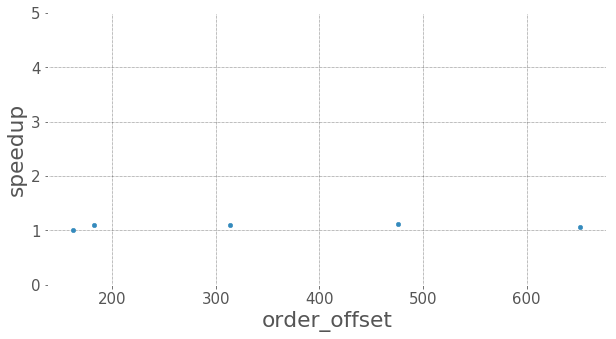

In [34]:
g_difference4.plot(kind='scatter', x='order_offset', y='speedup', ylim=[0,5], figsize=(10,5))

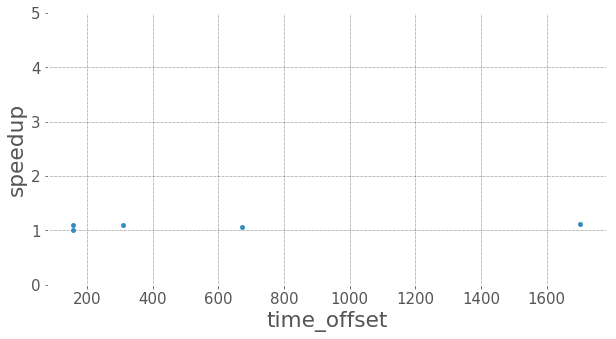

In [35]:
g_difference4.plot(kind='scatter', x='time_offset', y='speedup', ylim=[0,5], figsize=(10,5))

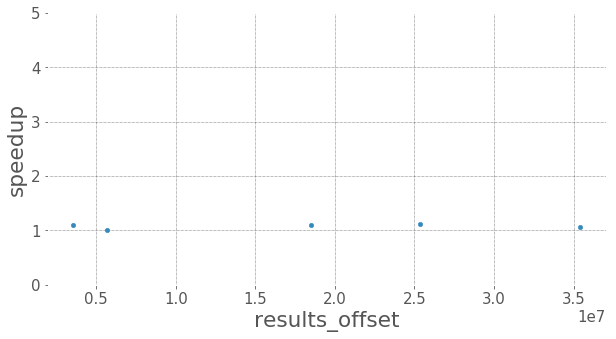

In [36]:
g_difference4.plot(kind='scatter', x='results_offset', y='speedup', ylim=[0,5], figsize=(10,5))

In [37]:
def create_offset_frame_group(g):
    

    m1 = g['flag'] == 'SUCCESS'
    m2 = g['correct'] == 'CORRECT'
    m3 = g['thread_type'] == 'stress'

    g_correct = g[m1 & m2 & m3]

    g_cleaned = g_correct.sort_values('cumul_time').reset_index()
    g_previous = g_cleaned.shift(+1)
    g_previous.dropna(inplace=True)

    diff_cols = ['overall_order_id', 'cumul_time', 'cumul_results']

    g_difference = pd.DataFrame(g_cleaned)
    g_difference.loc[:,diff_cols] = g_cleaned[diff_cols] - g_previous[diff_cols]
    g_difference.loc[:,'thread_id'] = g_cleaned['thread_id'].map(str) + \
                        "-" +  \
                        g_previous['thread_id'].map(lambda s: str(s)[:-2])

            
    g_difference['speedup'] = g_difference['runtime'].max() / g_difference['runtime']
    g_difference['net_gain'] = g_difference['runtime'].max() - g_difference['runtime']

    
    g_difference2 = g_difference.dropna()
    g_difference3 = g_difference2.set_index('index')
    g_difference4 = g_difference3.rename(columns={'cumul_time': 'time_offset', \
                                              'overall_order_id': 'order_offset', \
                                              'cumul_results': 'results_offset'})
       
    return g_difference4 
    

In [38]:
dfs = []
for i, g in grouped_per_query:
    dfs.append(create_offset_frame_group(g))
    
df_offsets = pd.concat(dfs)
df_offsets.head(n=5)

sim_id           query_name thread_id thread_type  \
index                                                                   
737    Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     15-18      stress   
1389   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     17-15      stress   
1551   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     14-17      stress   
1865   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     16-14      stress   
1042   Vir_N1_64_W1000_Opt  C1/C1_split1.sparql     15-14      stress   

       order_id  number_of_results    runtime     flag  correct  time_offset  \
index                                                                          
737          94               1424  48.751925  SUCCESS  CORRECT   157.499107   
1389        169               1424  49.794759  SUCCESS  CORRECT   672.043656   
1551        207               1424  53.286911  SUCCESS  CORRECT   158.560836   
1865        280               1424  48.074759  SUCCESS  CORRECT   309.018873   
1042        168               1424  46.815565  SUCCESS  CORRECT   559.219708   

       order_offset  results_offset   speedup  net_gain  
index                                                    
737           182.0       3547047.0  1.093022  4.534985  
1389          652.0      35423030.0  1.070131  3.492152  
1551          162.0       5661080.0  1.000000  0.000000  
1865          314.0      18519996.0  1.108418  5.212152  
1042          582.0      28858075.0  1.086551  4.051953

In [39]:
colormap1 = {
    "C" : "red",
    "F" : "blue",
    "S" : "green",
    "L" : "orange"
}




df_offsets['color_type'] = df_offsets['query_name'].apply(lambda n: colormap1[n[:1]])
df_offsets.head(n=5)


sim_id           query_name thread_id thread_type  \
index                                                                   
737    Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     15-18      stress   
1389   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     17-15      stress   
1551   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     14-17      stress   
1865   Vir_N1_64_W1000_Opt  C1/C1_split0.sparql     16-14      stress   
1042   Vir_N1_64_W1000_Opt  C1/C1_split1.sparql     15-14      stress   

       order_id  number_of_results    runtime     flag  correct  time_offset  \
index                                                                          
737          94               1424  48.751925  SUCCESS  CORRECT   157.499107   
1389        169               1424  49.794759  SUCCESS  CORRECT   672.043656   
1551        207               1424  53.286911  SUCCESS  CORRECT   158.560836   
1865        280               1424  48.074759  SUCCESS  CORRECT   309.018873   
1042        168               1424  46.815565  SUCCESS  CORRECT   559.219708   

       order_offset  results_offset   speedup  net_gain color_type  
index                                                               
737           182.0       3547047.0  1.093022  4.534985        red  
1389          652.0      35423030.0  1.070131  3.492152        red  
1551          162.0       5661080.0  1.000000  0.000000        red  
1865          314.0      18519996.0  1.108418  5.212152        red  
1042          582.0      28858075.0  1.086551  4.051953        red

In [40]:
df_offsets[df_offsets['color_type'] == 'orange'].head(n=5)

sim_id           query_name thread_id thread_type  \
index                                                                   
594    Vir_N1_64_W1000_Opt  L1/L1_split0.sparql     15-18      stress   
796    Vir_N1_64_W1000_Opt  L1/L1_split0.sparql     16-15      stress   
943    Vir_N1_64_W1000_Opt  L1/L1_split0.sparql     14-16      stress   
1601   Vir_N1_64_W1000_Opt  L1/L1_split0.sparql     17-14      stress   
1912   Vir_N1_64_W1000_Opt  L1/L1_split1.sparql     16-17      stress   

       order_id  number_of_results   runtime     flag  correct  time_offset  \
index                                                                         
594          69                  7  0.005736  SUCCESS  CORRECT     1.932588   
796          66                  7  0.013344  SUCCESS  CORRECT   236.417369   
943          91                  7  0.005948  SUCCESS  CORRECT   100.749467   
1601        222                  7  0.008917  SUCCESS  CORRECT   676.419233   
1912        298                  4  0.007310  SUCCESS  CORRECT  1200.358851   

       order_offset  results_offset   speedup  net_gain color_type  
index                                                               
594            11.0         23157.0  2.326094  0.007607     orange  
796           202.0       8944277.0  1.000000  0.000000     orange  
943           147.0       7709664.0  2.243425  0.007396     orange  
1601          658.0      31167286.0  1.496436  0.004427     orange  
1912         1209.0      64044431.0  1.046315  0.000339     orange

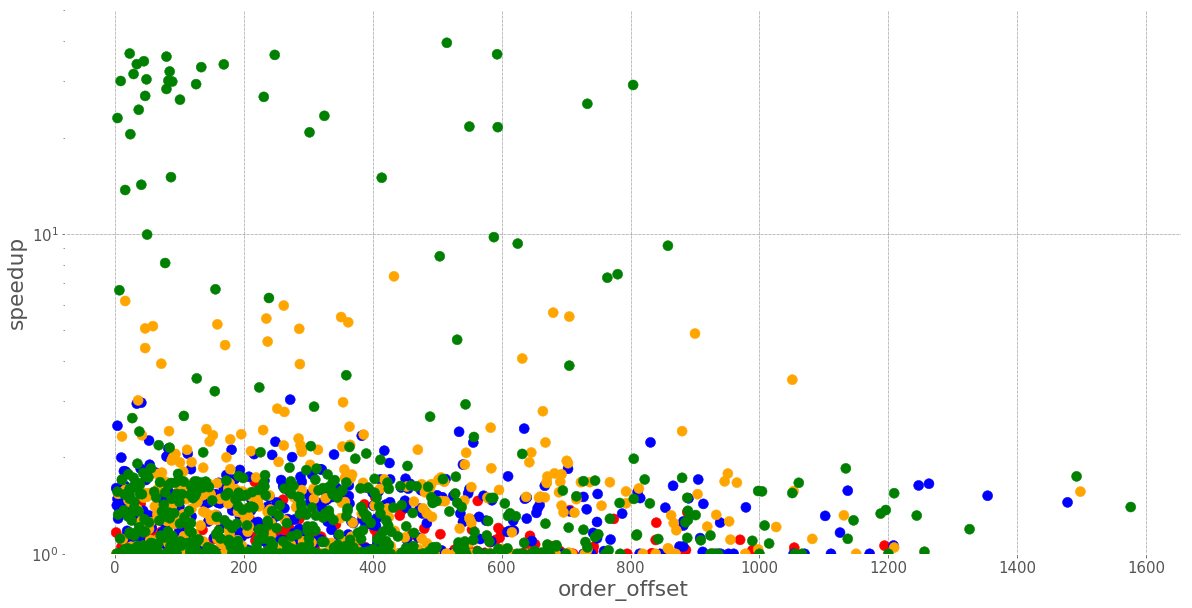

In [41]:
mask1 = df_offsets['color_type'] == 'green'
df_offsets.plot(kind='scatter', x='order_offset', y='speedup', logy=True, c=df_offsets['color_type'], \
                figsize=(20,10), s=100, ylim=[1,50])

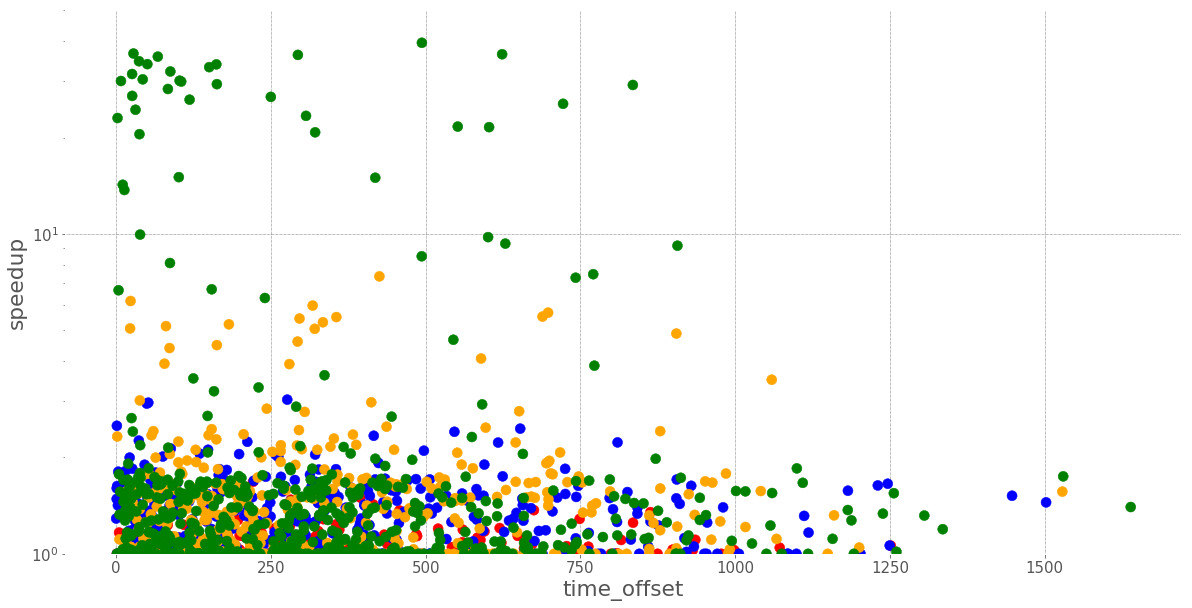

In [42]:
df_offsets.plot(kind='scatter', x='time_offset', y='speedup', c=df_offsets['color_type'], logy=True, \
                figsize=(20,10), s=100, ylim=[1,50])
               

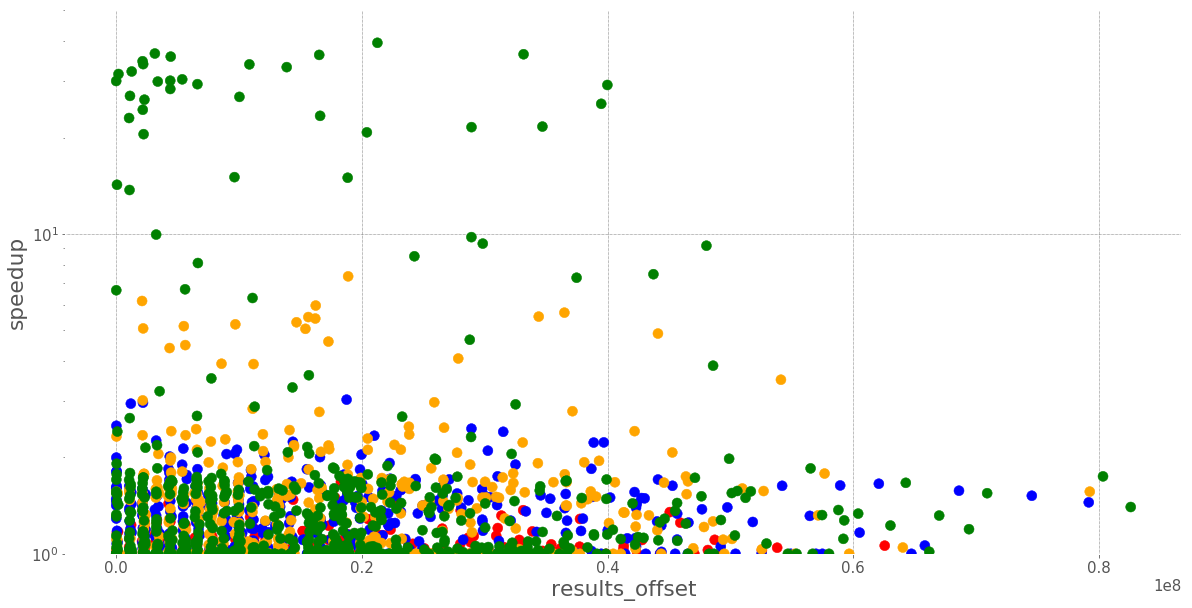

In [43]:
df_offsets.plot(kind='scatter', x='results_offset', y='speedup', c=df_offsets['color_type'], logy=True, \
                figsize=(20,10), s=100, ylim=[1,50])

## But we are probably looking at noise? 

* queries which run in 10ms might have a variance of 5 ms => much easier to get a big speedup due to noise, let's have a look at the net gain in query runtime between slowest and fastest query, since that might in fact be the true benefit in the system!

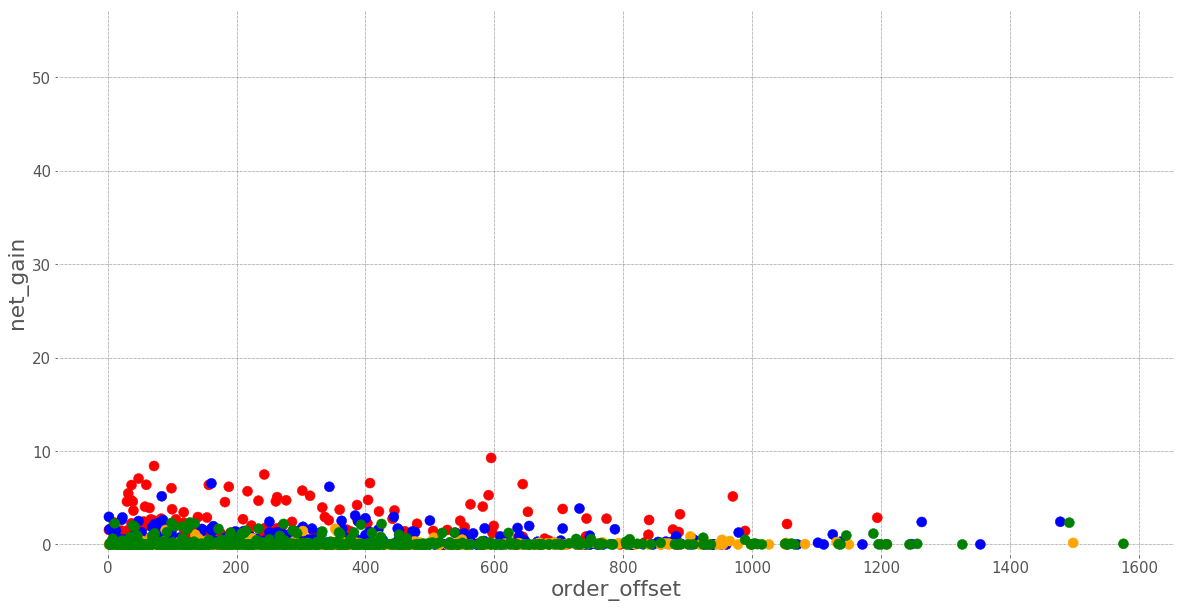

In [44]:
df_offsets.plot(kind='scatter', x='order_offset', y='net_gain', logy=False, c=df_offsets['color_type'], \
                figsize=(20,10), s=100, ylim=[-1,df_offsets['runtime'].max()])

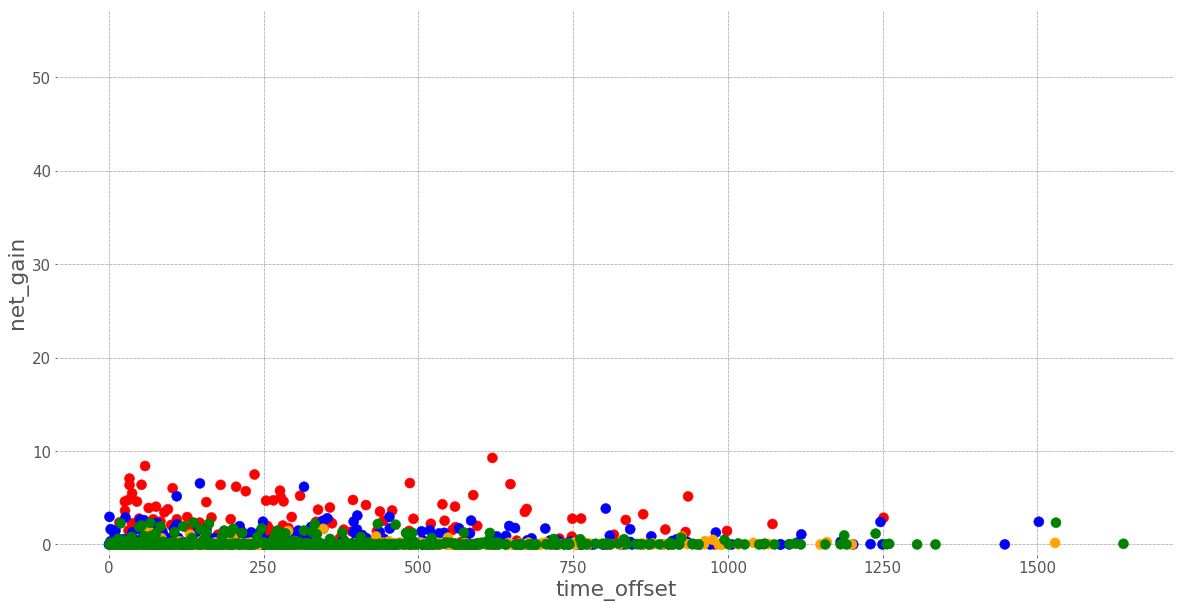

In [45]:
df_offsets.plot(kind='scatter', x='time_offset', y='net_gain', logy=False, c=df_offsets['color_type'], \
                figsize=(20,10), s=100, ylim=[-1,df_offsets['runtime'].max()])

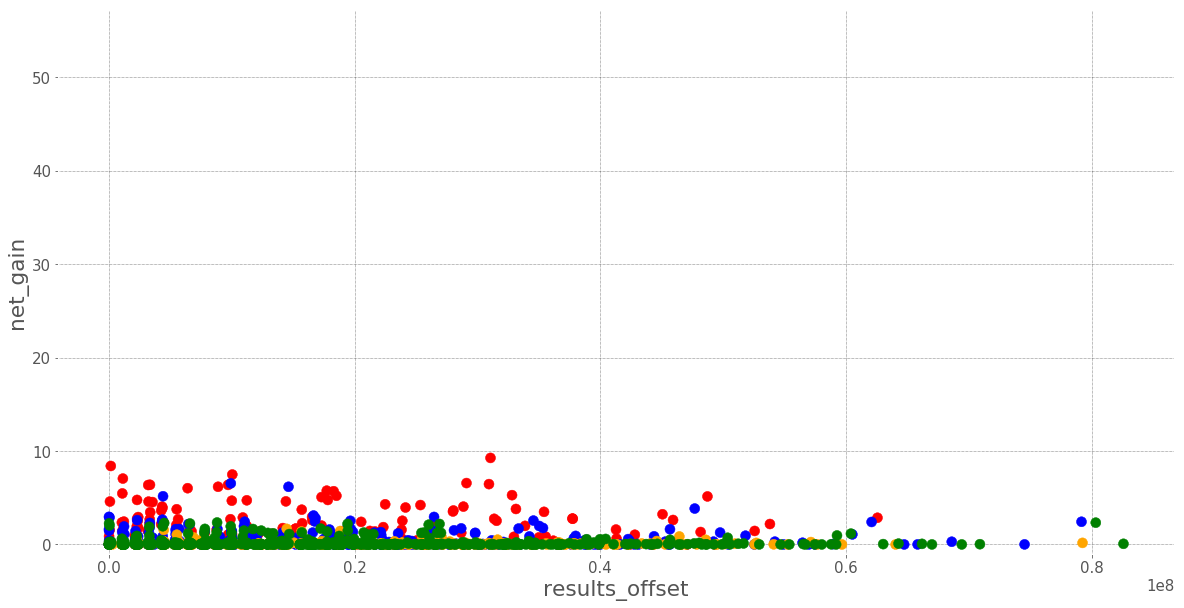

In [46]:
df_offsets.plot(kind='scatter', x='results_offset', y='net_gain', logy=False, c=df_offsets['color_type'], \
                figsize=(20,10), s=100, ylim=[-1,df_offsets['runtime'].max()])

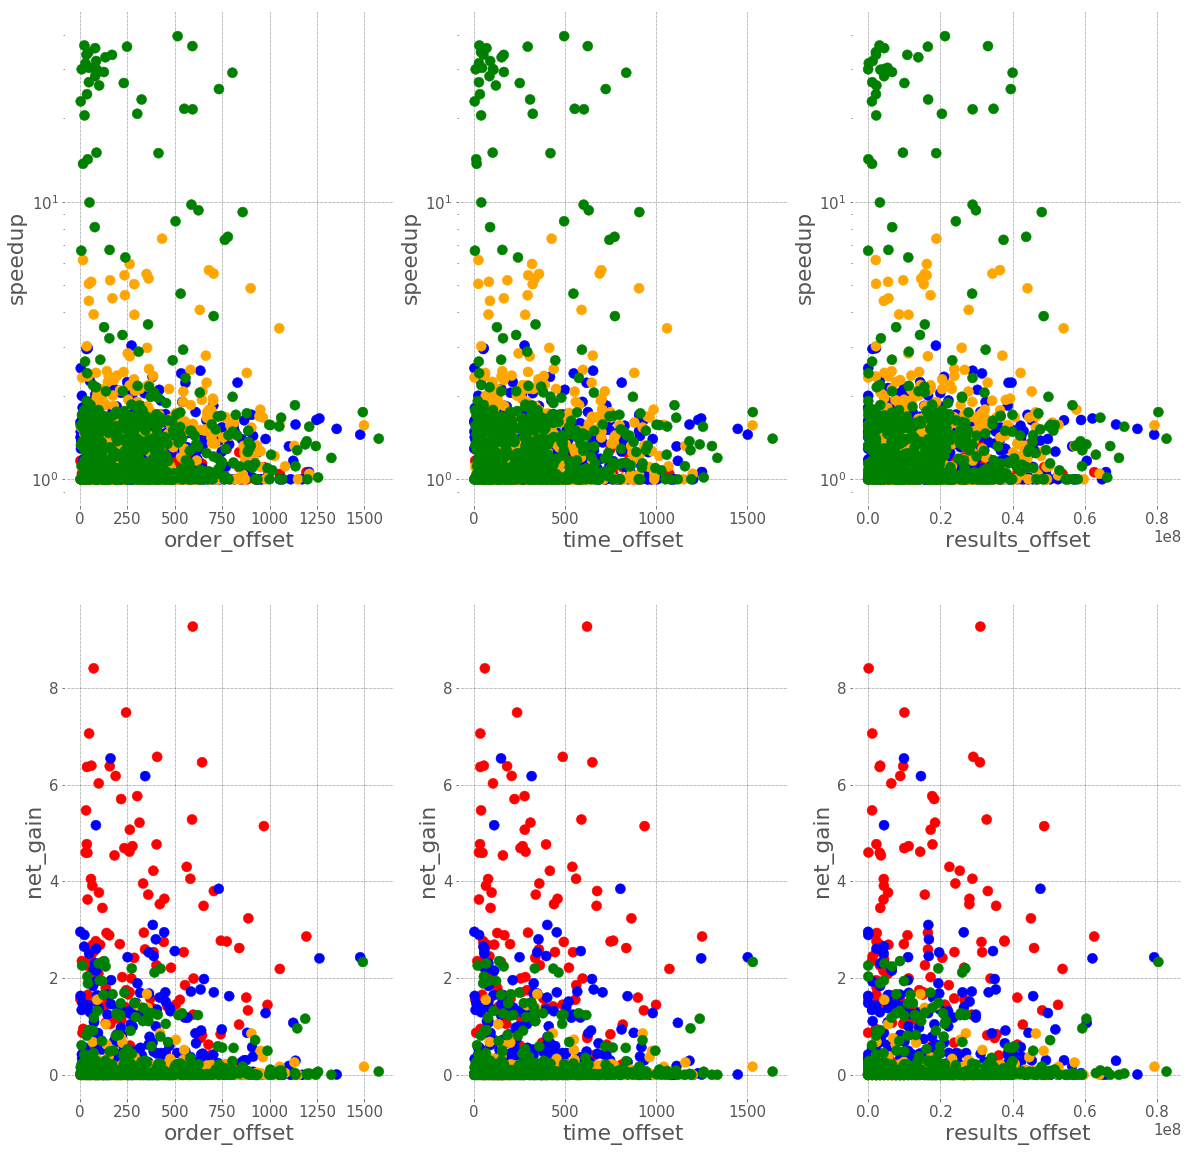

In [47]:


df = pd.read_csv(generate_sorted_events_filename(tup), sep='\t', index_col=0)
grouped_per_query = df.groupby('query_name')

dfs = []
for i, g in grouped_per_query:
    dfs.append(create_offset_frame_group(g))
    
df_offsets = pd.concat(dfs)
df_offsets['color_type'] = df_offsets['query_name'].apply(lambda n: colormap1[n[:1]])


fig, ax = plt.subplots(2,3, figsize=(20,20))

df_offsets.plot(kind='scatter', x='order_offset', y='speedup', logy=True, c=df_offsets['color_type'], s=100, ax=ax[0][0])
df_offsets.plot(kind='scatter', x='time_offset', y='speedup', logy=True, c=df_offsets['color_type'], s=100, ax=ax[0][1])
df_offsets.plot(kind='scatter', x='results_offset', y='speedup', logy=True, c=df_offsets['color_type'], s=100, ax=ax[0][2])

df_offsets.plot(kind='scatter', x='order_offset', y='net_gain', logy=False, c=df_offsets['color_type'], s=100, ax=ax[1][0])
df_offsets.plot(kind='scatter', x='time_offset', y='net_gain', logy=False, c=df_offsets['color_type'], s=100, ax=ax[1][1])
df_offsets.plot(kind='scatter', x='results_offset', y='net_gain', logy=False, c=df_offsets['color_type'], s=100, ax=ax[1][2])



## D1 (NoSQL,1,64,Watdiv1000M,Default)   => #query events = 1 x 400  + 5 x 400 
## D2 (NoSQL,1,64,Watdiv1000M,Optimized) => #query events = 1 x 400  + 5 x 400 
## D3 (Other,1,64,Watdiv1000M,Default)   => #query events = 1 x 400  + 5 x 400 

In [48]:
def generate_offset_report(tup, ax):
    
    colormap1 = {
        "C" : "red",
        "F" : "blue",
        "S" : "green",
        "L" : "orange"
    }

    df = pd.read_csv(generate_sorted_events_filename(tup), sep='\t', index_col=0)
    grouped_per_query = df.groupby('query_name')

    dfs = []
    for i, g in grouped_per_query:
        dfs.append(create_offset_frame_group(g))
       
    
    df_offsets = pd.concat(dfs)
    df_offsets['color_type'] = df_offsets['query_name'].apply(lambda n: colormap1[n[:1]])
    
    if ax is not None:

        df_offsets.plot(kind='scatter', x='order_offset', y='speedup', logy=True, c=df_offsets['color_type'], s=100, ax=ax[0][0])
        df_offsets.plot(kind='scatter', x='time_offset', y='speedup', logy=True, c=df_offsets['color_type'], s=100, ax=ax[0][1])
        df_offsets.plot(kind='scatter', x='results_offset', y='speedup', logy=True, c=df_offsets['color_type'], s=100, ax=ax[0][2])

        df_offsets.plot(kind='scatter', x='order_offset', y='net_gain', logy=False, c=df_offsets['color_type'], s=100, ax=ax[1][0])
        df_offsets.plot(kind='scatter', x='time_offset', y='net_gain', logy=False, c=df_offsets['color_type'], s=100, ax=ax[1][1])
        df_offsets.plot(kind='scatter', x='results_offset', y='net_gain', logy=False, c=df_offsets['color_type'], s=100, ax=ax[1][2])

    
    return df_offsets

In [49]:
tuple_list = [ \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Default', '')  , \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Default', '')     , \
                ('ES', 1, 64,'Watdiv1000M', 'Default', '')          , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Default', '')    , \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Optimized', ''), \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Optimized', '')   , \
                #('ES', 1, 64,'Watdiv1000M', 'Optimized', '')       , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Optimized', '')  , \
                ('Fuseki', 1, 64,'Watdiv1000M', 'Default', '')      , \
                ('FluidOps', 3, 64,'Watdiv1000M', 'Default', '')    , \
                ('LDF', 1, 64,'Watdiv1000M', 'Default', '')         , \
                ('LDF', 3, 64,'Watdiv1000M', 'Default', '')           \
             ]




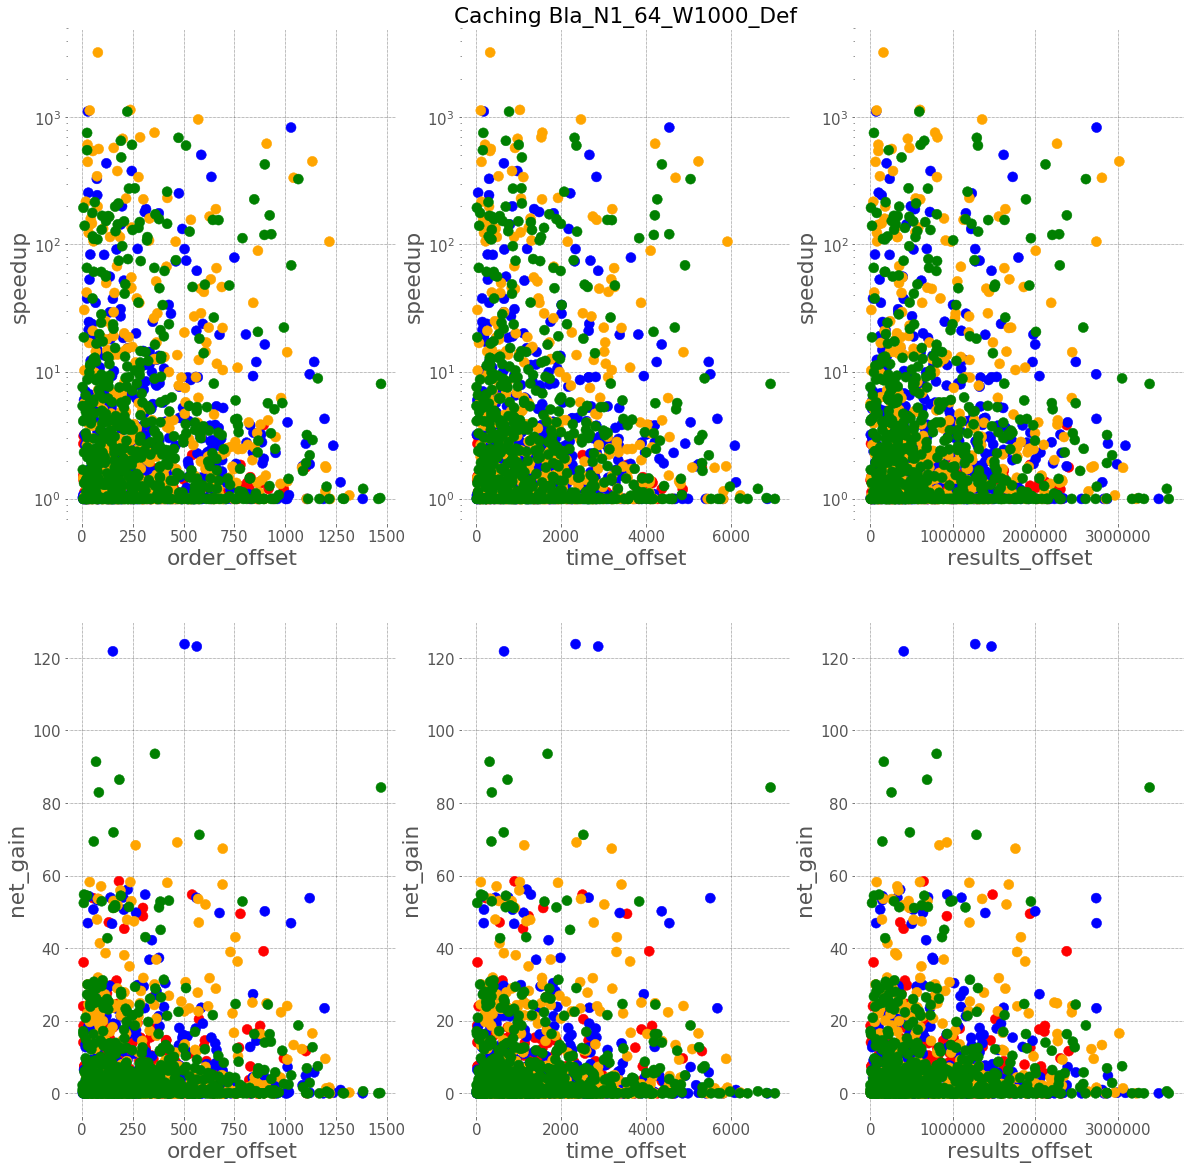

In [50]:
tup = tuple_list[0]
fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

### Runtime vs speedup: we zien dat speedup vooral voor kleine runtimes is => net_gain wsch meer geschikt

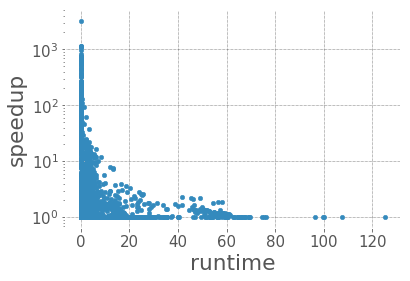

In [51]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

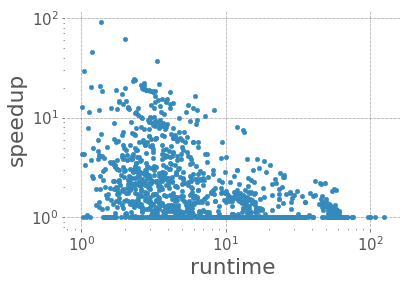

In [52]:
offset_df[offset_df['runtime'] > 1.0].plot(kind='scatter', y='speedup', x='runtime', logy=True, logx=True)

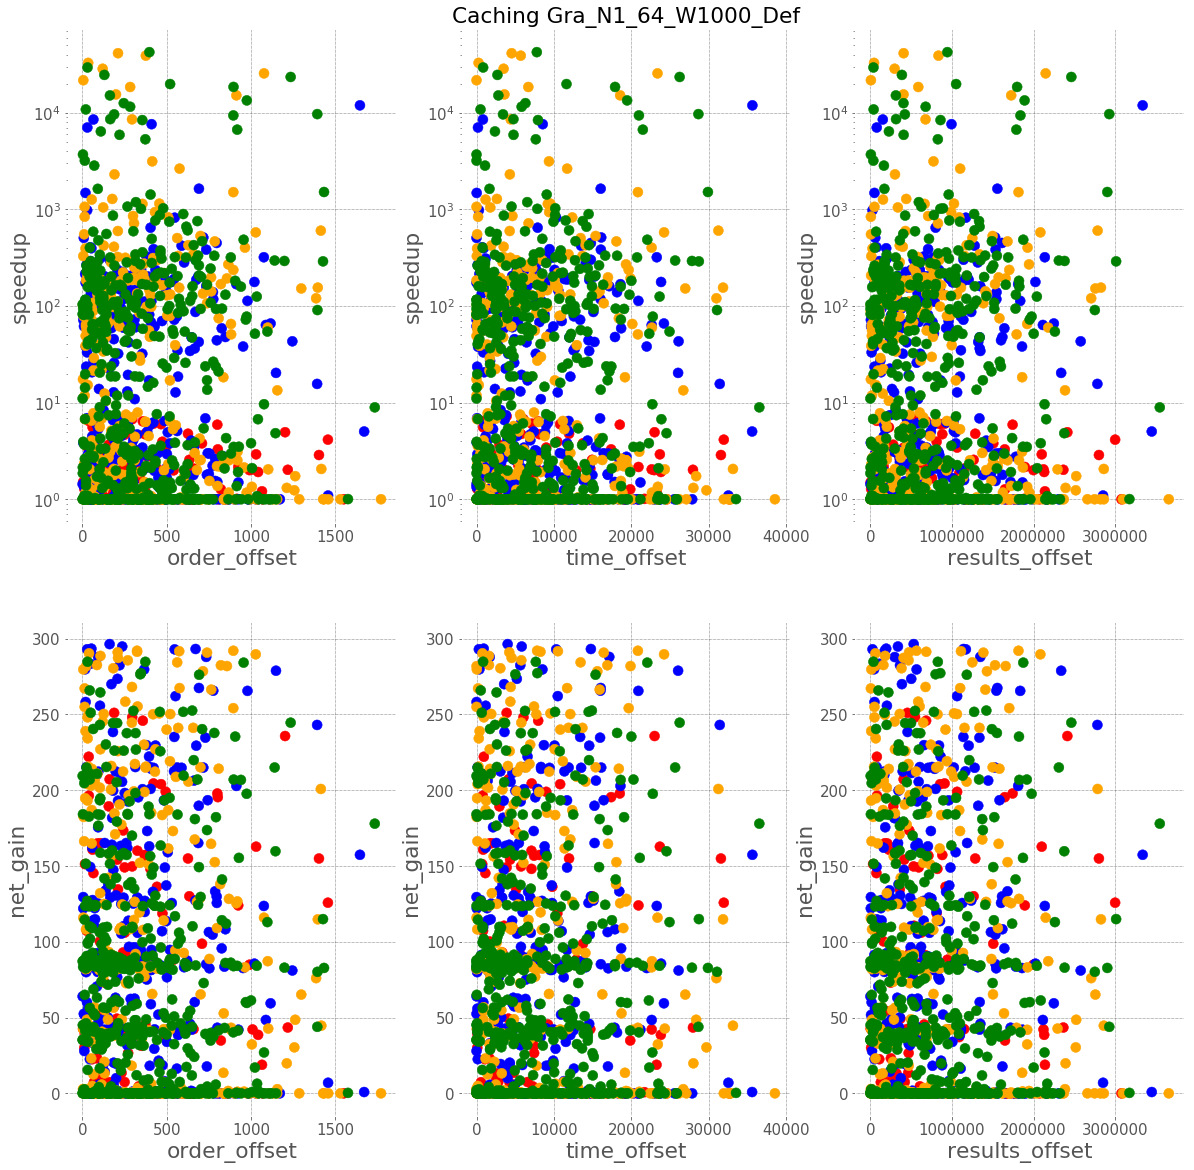

In [53]:
tup = tuple_list[1]
fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

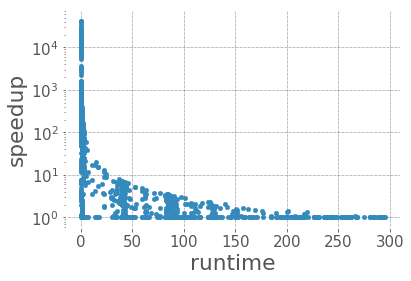

In [54]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

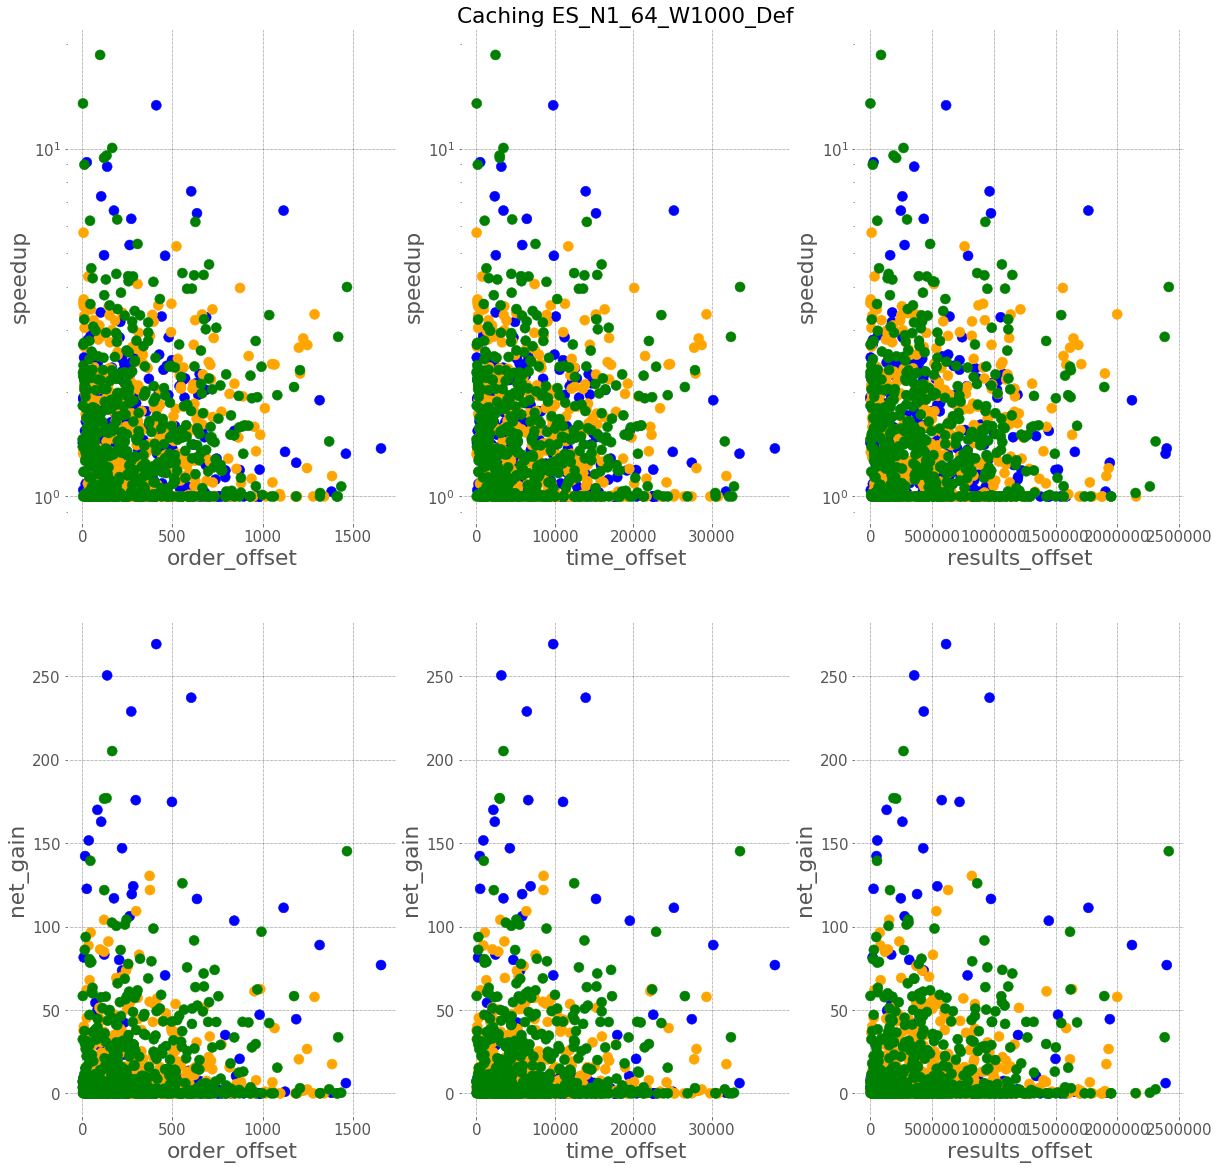

In [55]:
tup = tuple_list[2]
fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

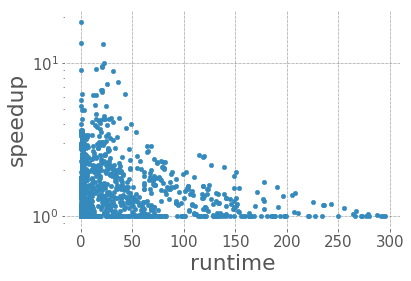

In [56]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

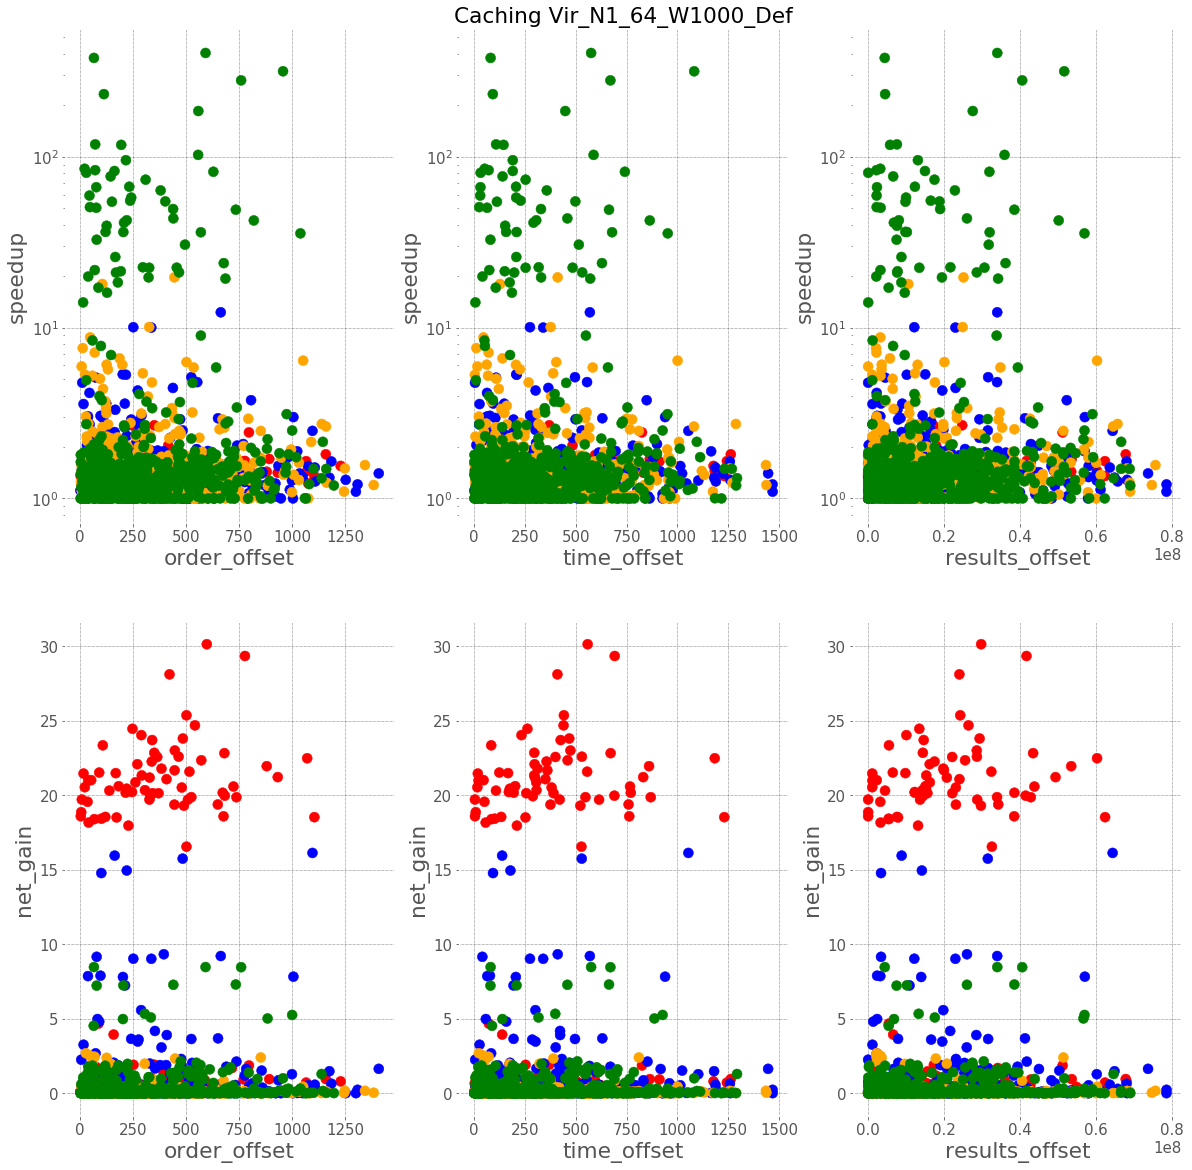

In [57]:
tup = tuple_list[3]
fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

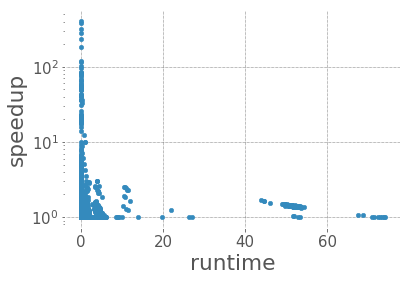

In [58]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

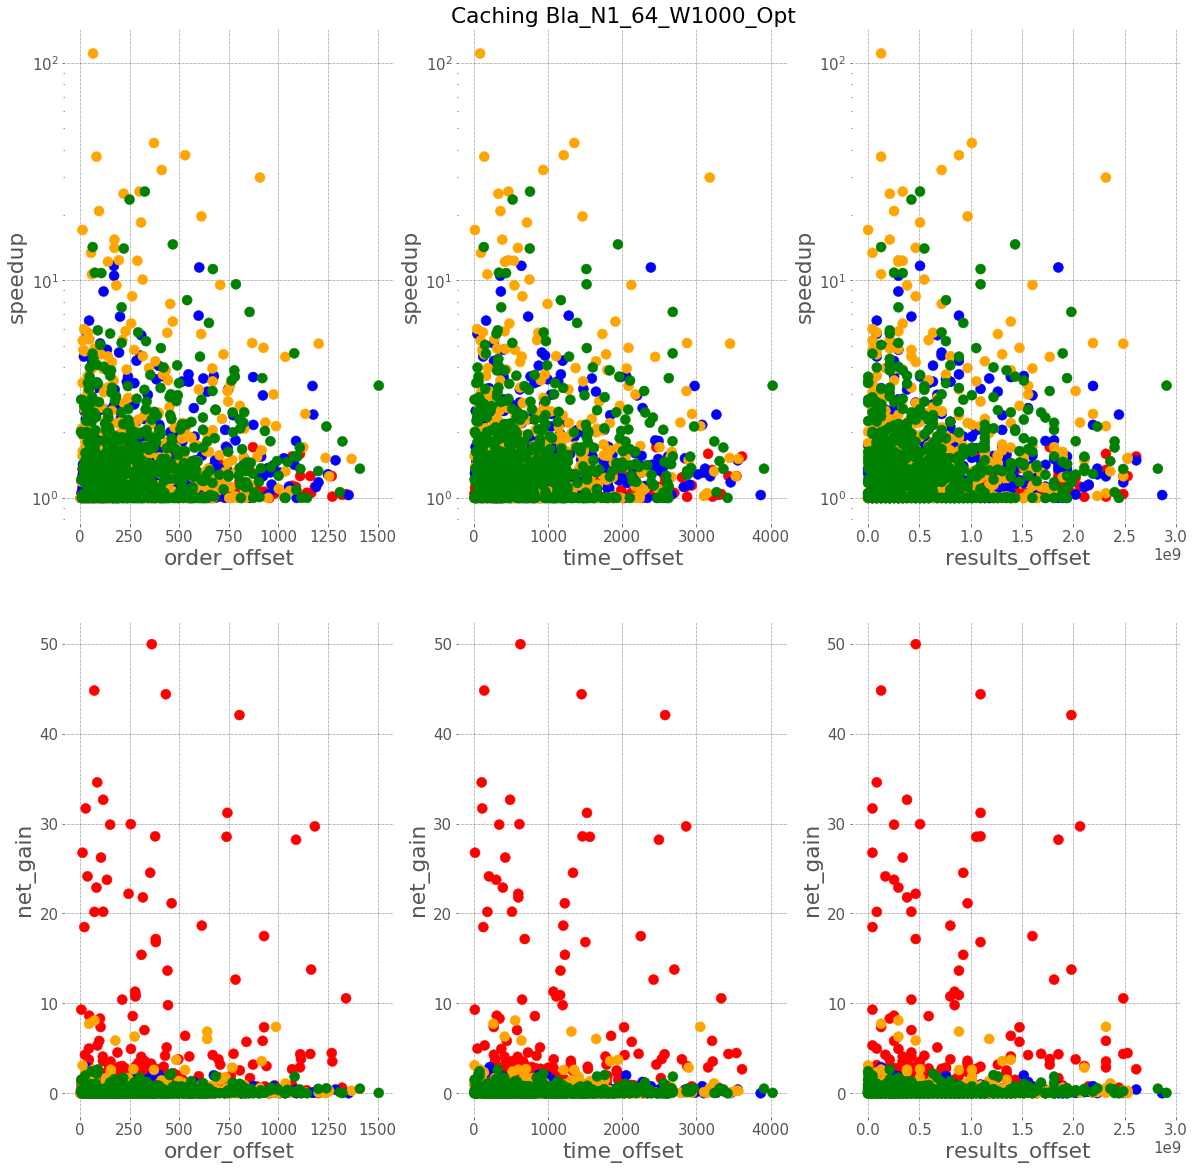

In [59]:
tup = tuple_list[4]
fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

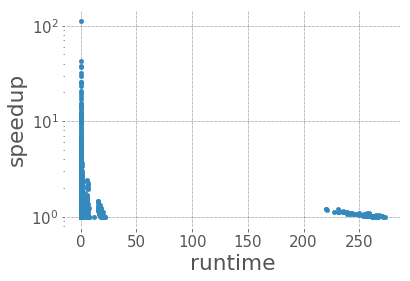

In [60]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

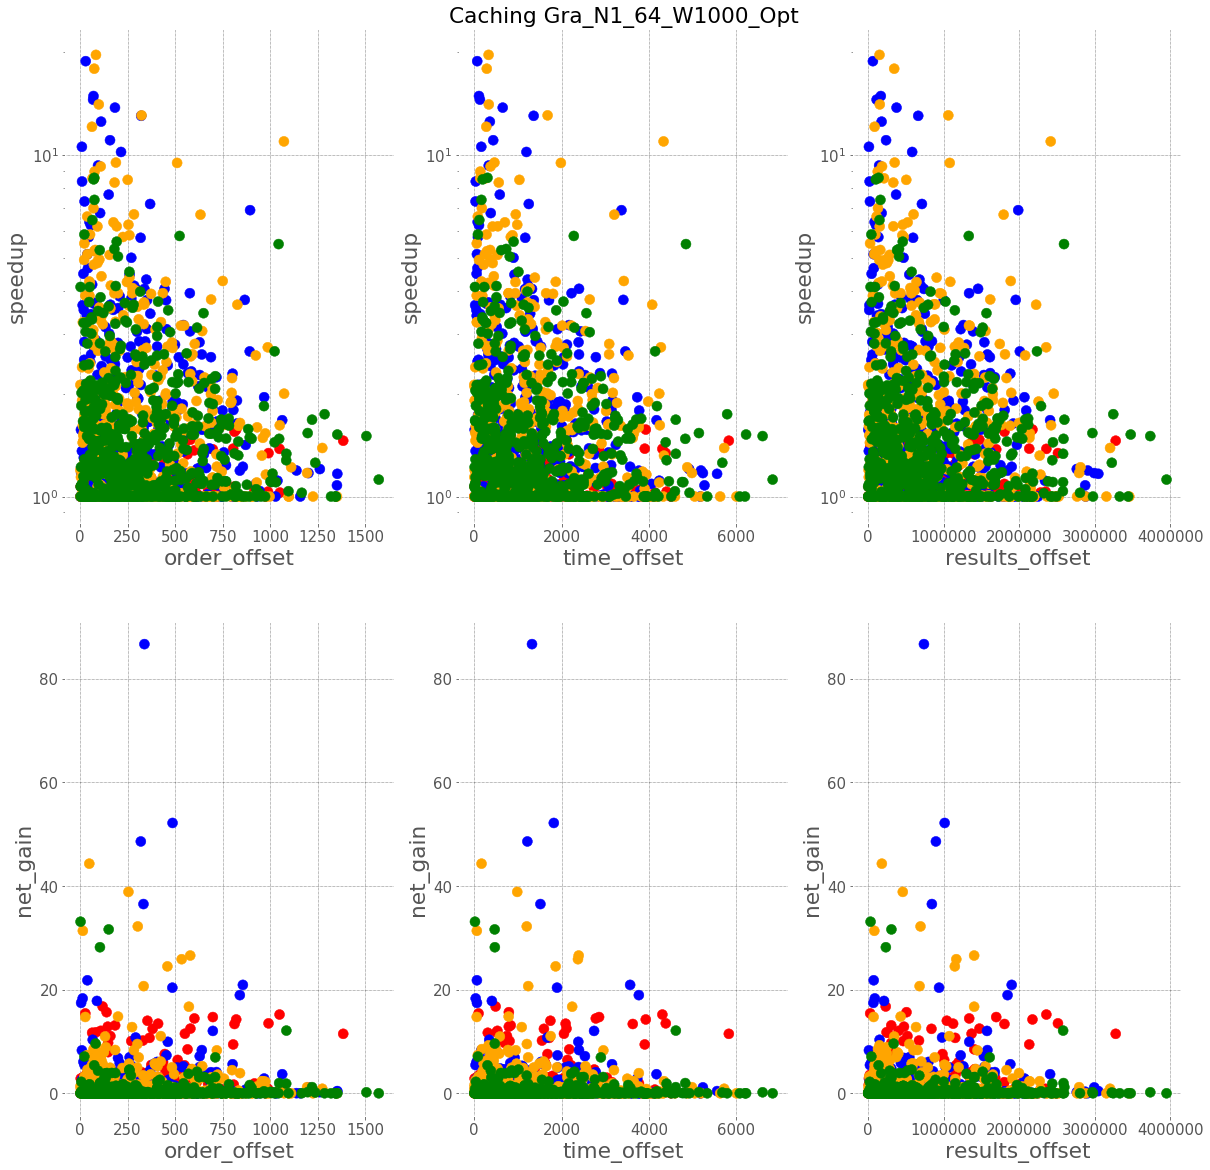

In [61]:
tup = tuple_list[5]
fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

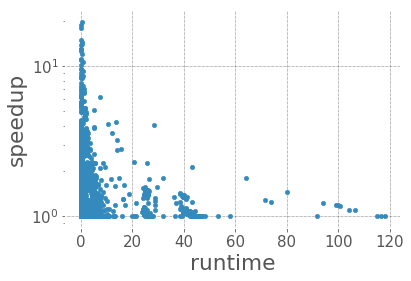

In [62]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

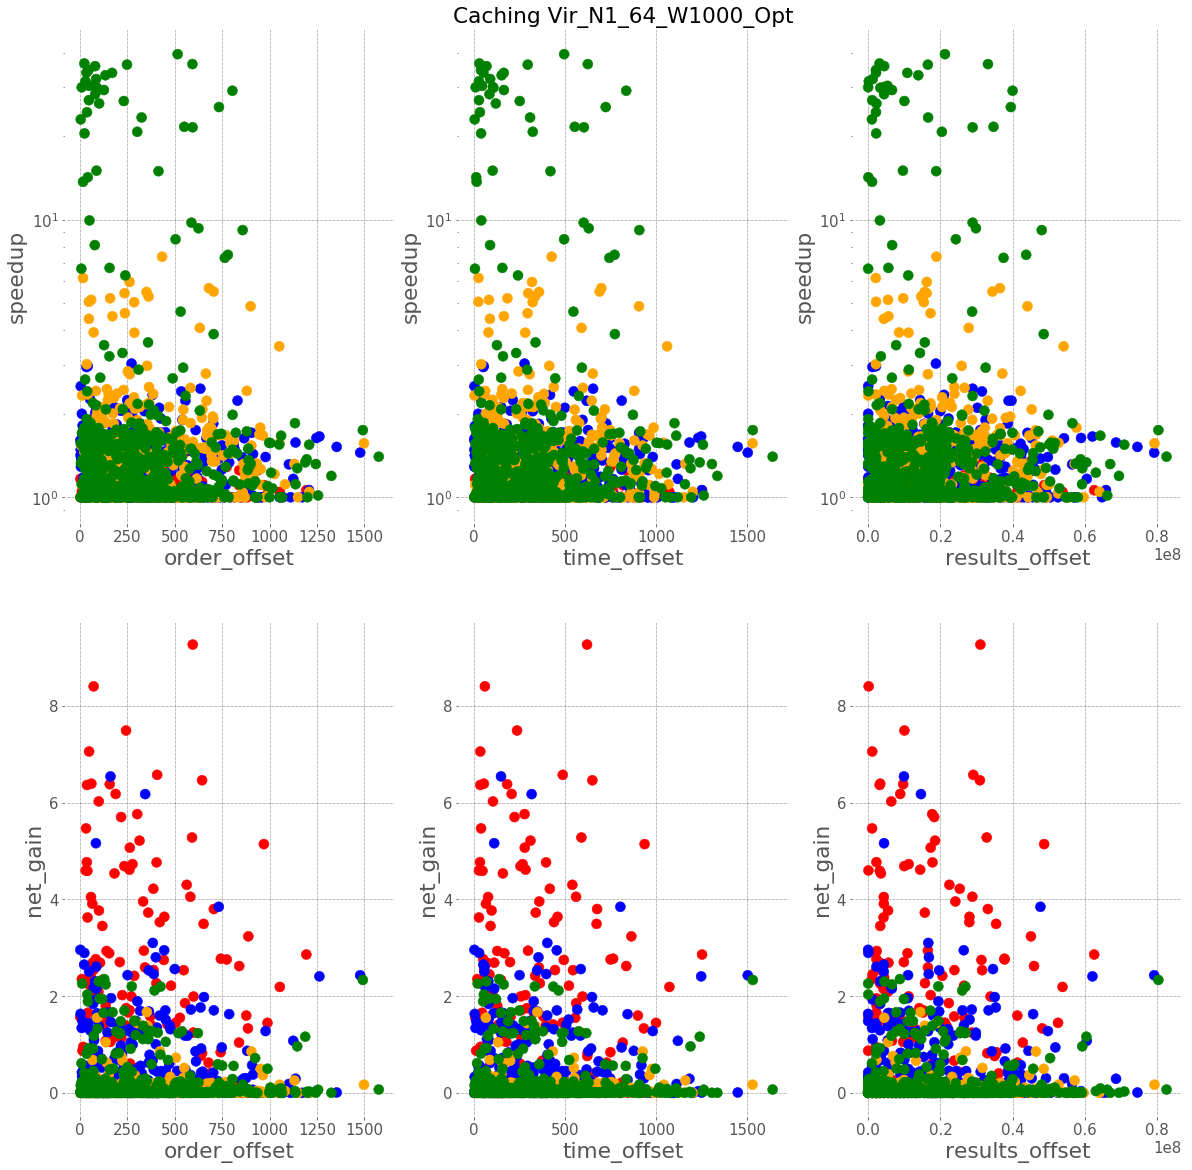

In [63]:
tup = tuple_list[6]
fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

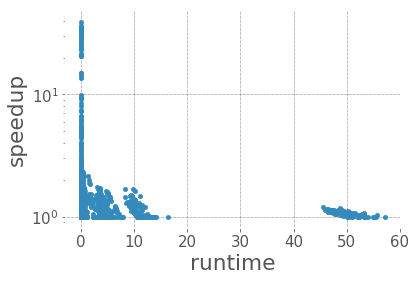

In [64]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

In [65]:
tup = tuple_list[7]
print(generateSimulationID(tup))
print("Only warmup")
#fig, ax = plt.subplots(2,3, figsize=(20,20))
#offset_df = generate_offset_report(tup,ax)
#ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

Fuseki_N1_64_Watdiv1000M_Default
Only warmup


In [66]:
#offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

In [67]:
tup = tuple_list[8]
print(generateSimulationID(tup))
print("Only warmup")

#fig, ax = plt.subplots(2,3, figsize=(20,20))
#offset_df = generate_offset_report(tup,ax)
#ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

FluidOps_N3_64_Watdiv1000M_Default
Only warmup


In [68]:
#offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

In [69]:
tup = tuple_list[9]
print(generateSimulationID(tup))
print("Only warmup")
#fig, ax = plt.subplots(2,3, figsize=(20,20))
#offset_df = generate_offset_report(tup,ax)
#ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

LDF_N1_64_Watdiv1000M_Default
Only warmup


In [70]:
#offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

## E (Other,1,64,Watdiv100M,Default)    => #query events = 1 x 400  + 5 x 400 


In [71]:
tuple_list = [('Fuseki', 1, 64,'Watdiv100M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv100M', 'Default', '')]  


Fuseki_N1_64_Watdiv100M_Default


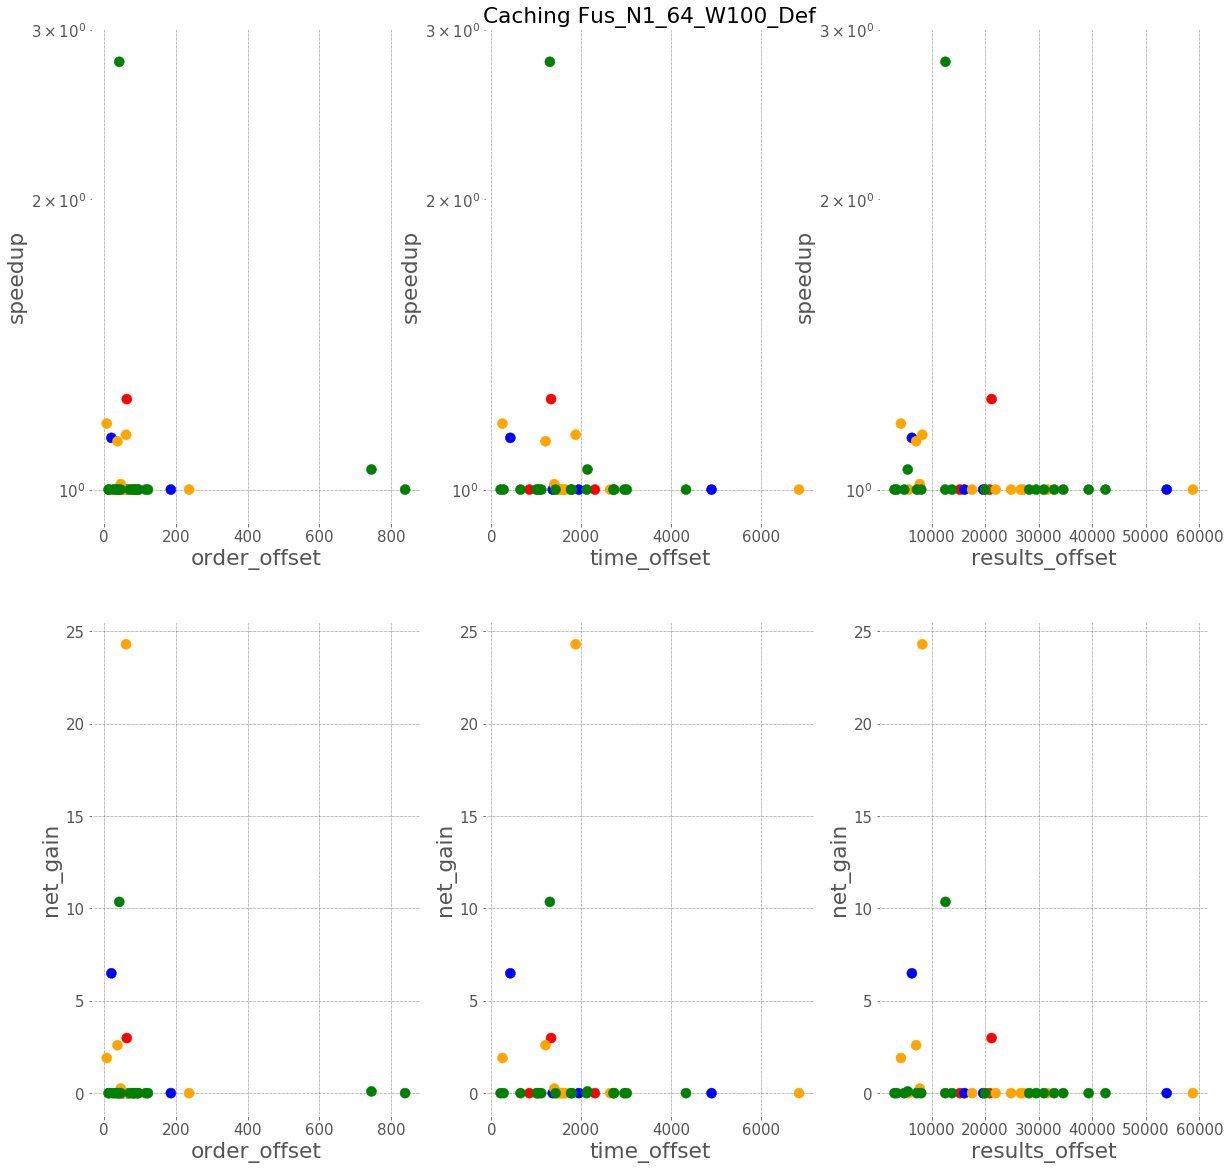

In [72]:
tup = tuple_list[0]
print(generateSimulationID(tup))
fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

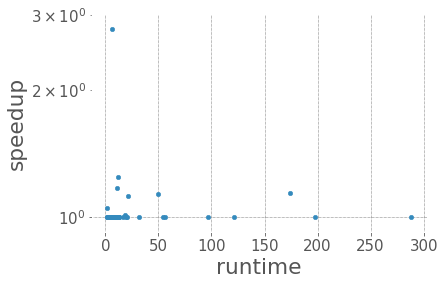

In [73]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

In [74]:
tup = tuple_list[1]
print(generateSimulationID(tup))
print("only warmup")
#fig, ax = plt.subplots(2,3, figsize=(20,20))
#offset_df = generate_offset_report(tup,ax)
#ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

FluidOps_N3_64_Watdiv100M_Default
only warmup


In [75]:
#offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

LDF_N1_64_Watdiv100M_Default


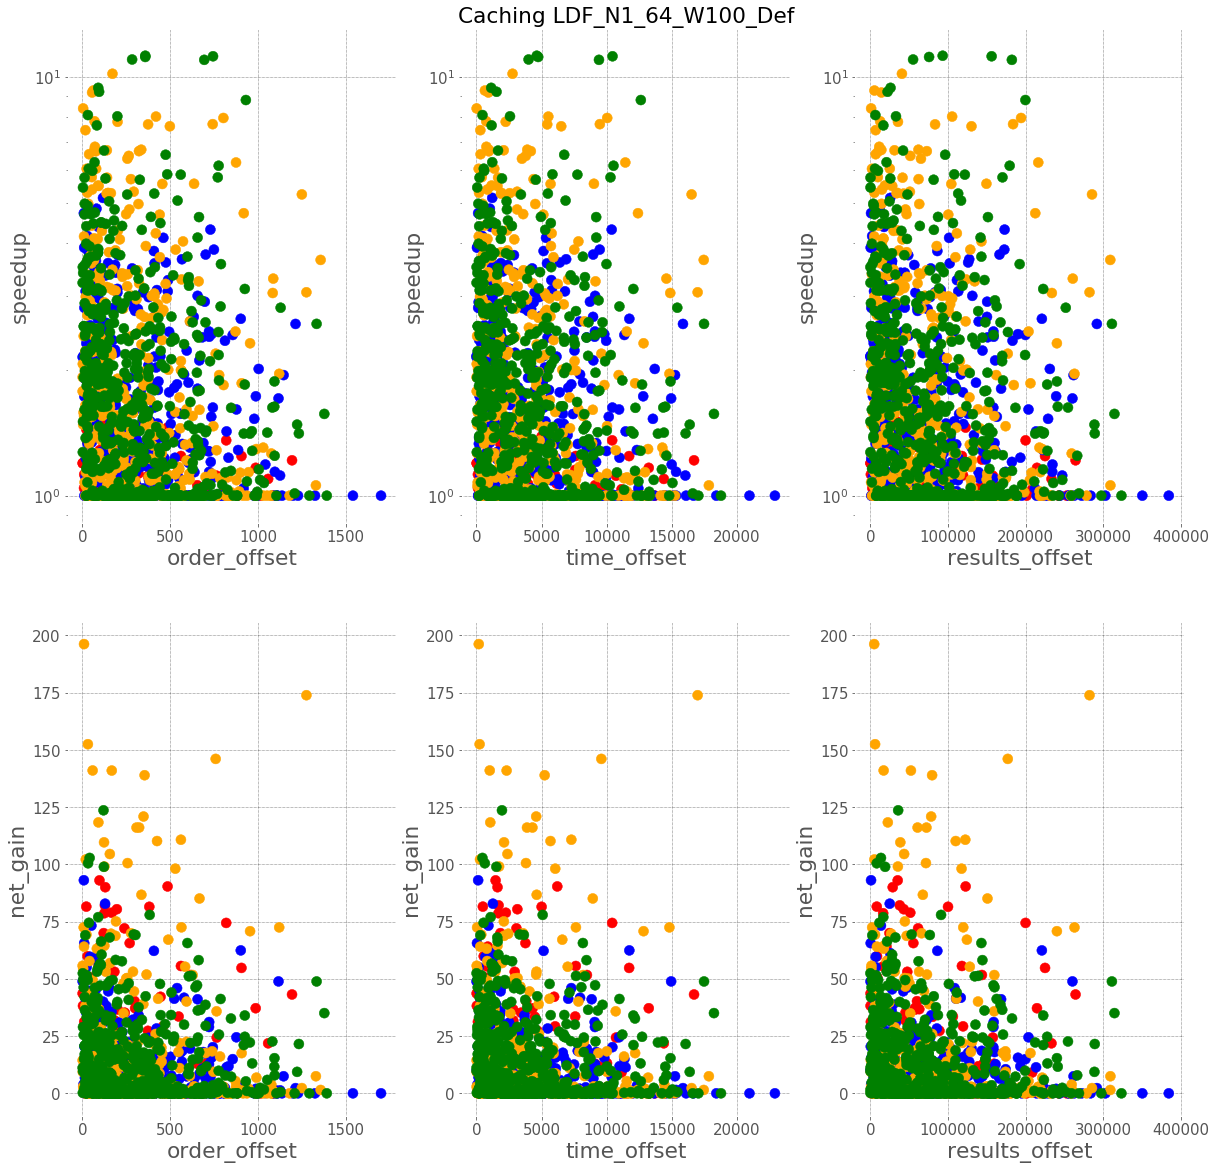

In [76]:
tup = tuple_list[2]
print(generateSimulationID(tup))

fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

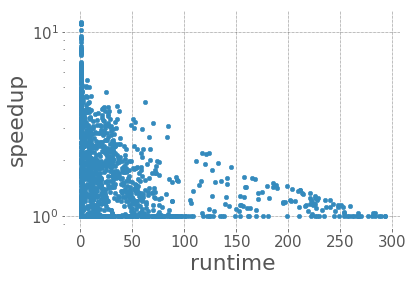

In [77]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

LDF_N3_64_Watdiv100M_Default


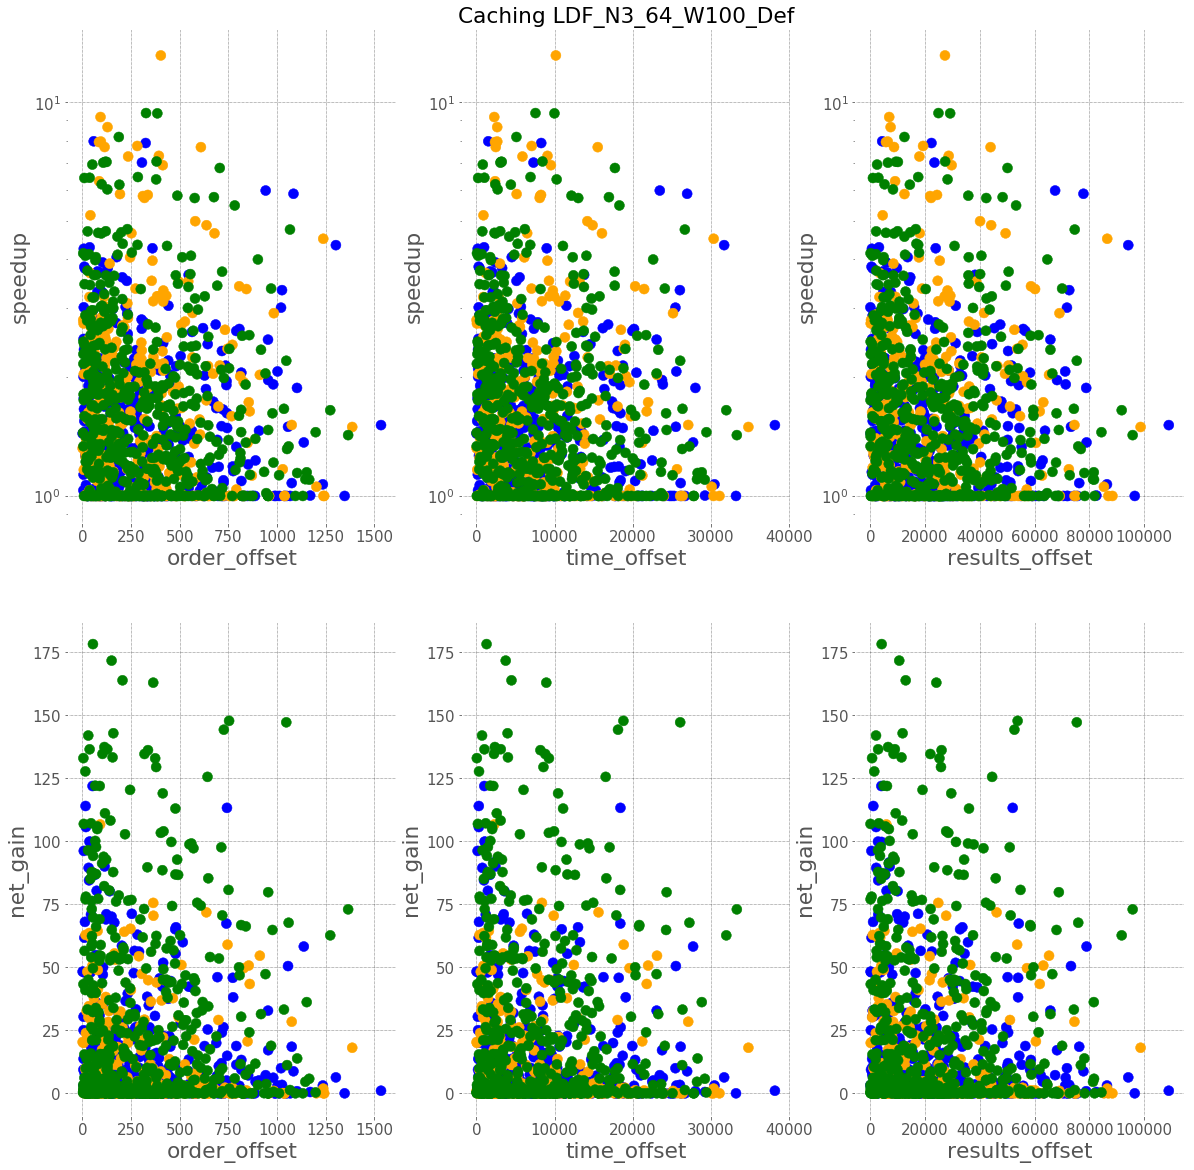

In [78]:
tup = tuple_list[3]
print(generateSimulationID(tup))

fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,ax)
ax[0][1].set_title('Caching ' + generateSimulationIDCompact(tup))

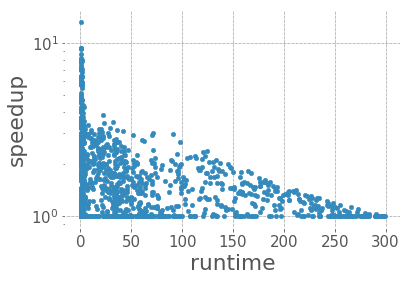

In [79]:
offset_df.plot(kind='scatter', y='speedup', x='runtime', logy=True)

# Other ways of visualizing caching effects?

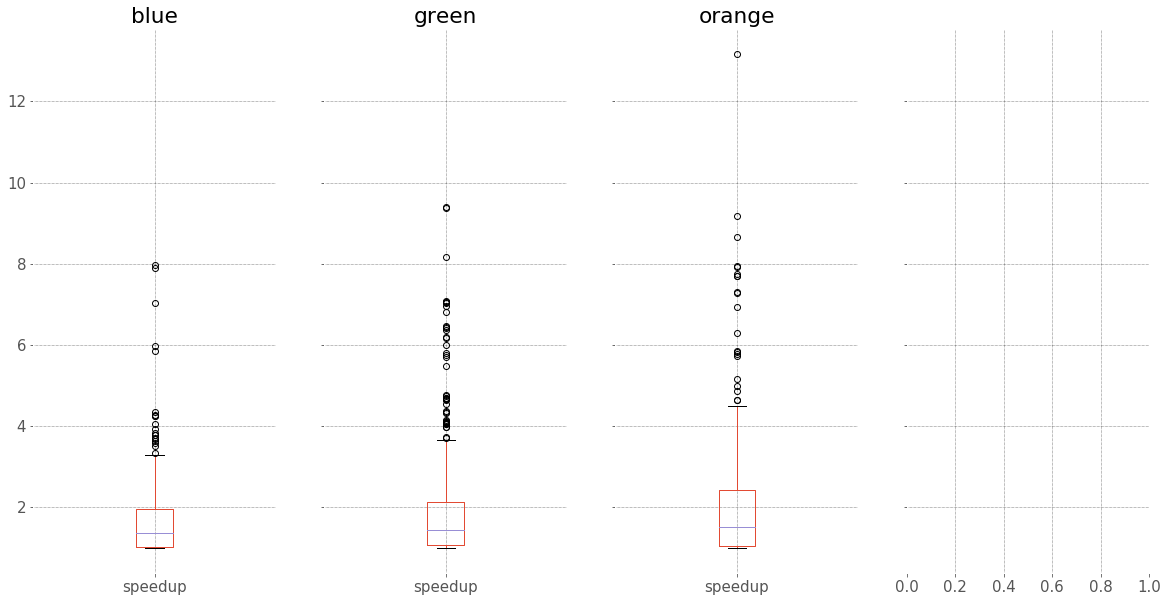

In [80]:
fig, ax = plt.subplots(1,4, figsize=(20,10), sharey=True)
i=0
for c, df in offset_df.groupby('color_type'):
    df.plot(kind='box', y='speedup', ax=ax[i], title=c)
    i+=1

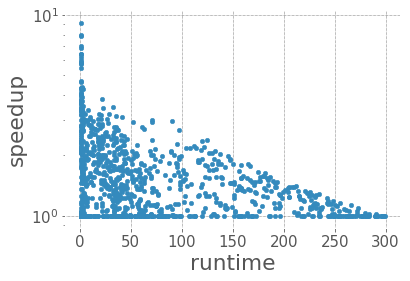

In [81]:
offset_df[offset_df['runtime']>1.0].plot(kind='scatter', y='speedup', x='runtime', logy=True)

In [82]:
tuple_list = [ \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Default', '')  , \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Default', '')     , \
                ('ES', 1, 64,'Watdiv1000M', 'Default', '')          , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Default', '')    , \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Optimized', ''), \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Optimized', '')   , \
                #('ES', 1, 64,'Watdiv1000M', 'Optimized', '')       , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Optimized', '')  , \
                ('Fuseki', 1, 64,'Watdiv1000M', 'Default', '')      , \
                ('FluidOps', 3, 64,'Watdiv1000M', 'Default', '')    , \
                ('LDF', 1, 64,'Watdiv1000M', 'Default', '')         , \
                ('LDF', 3, 64,'Watdiv1000M', 'Default', '')           \
             ]

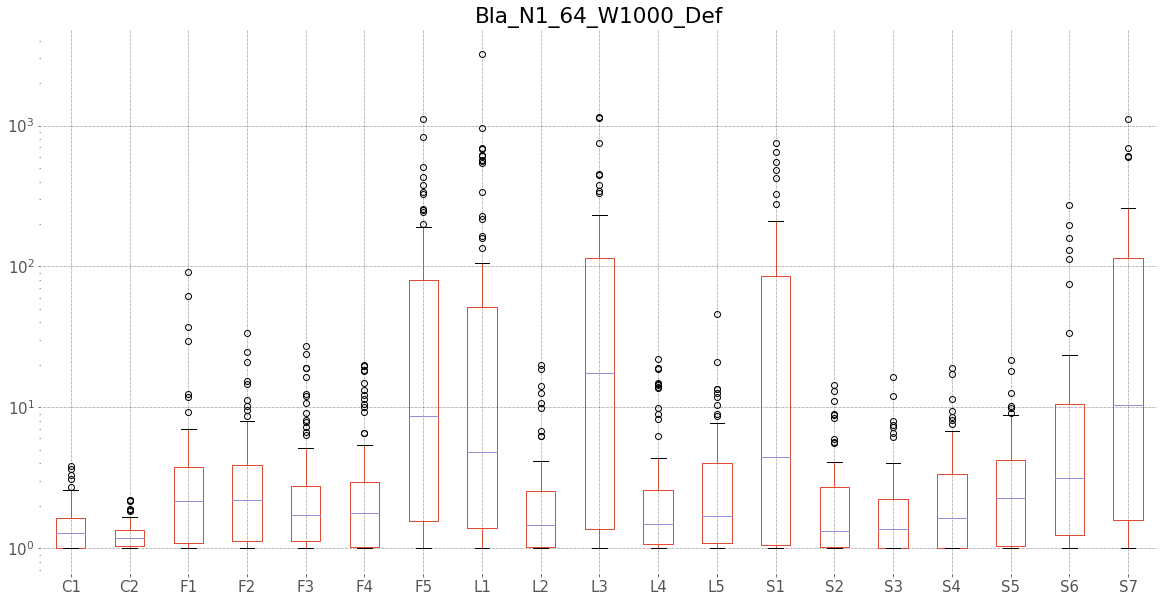

In [83]:
tup = tuple_list[0]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)

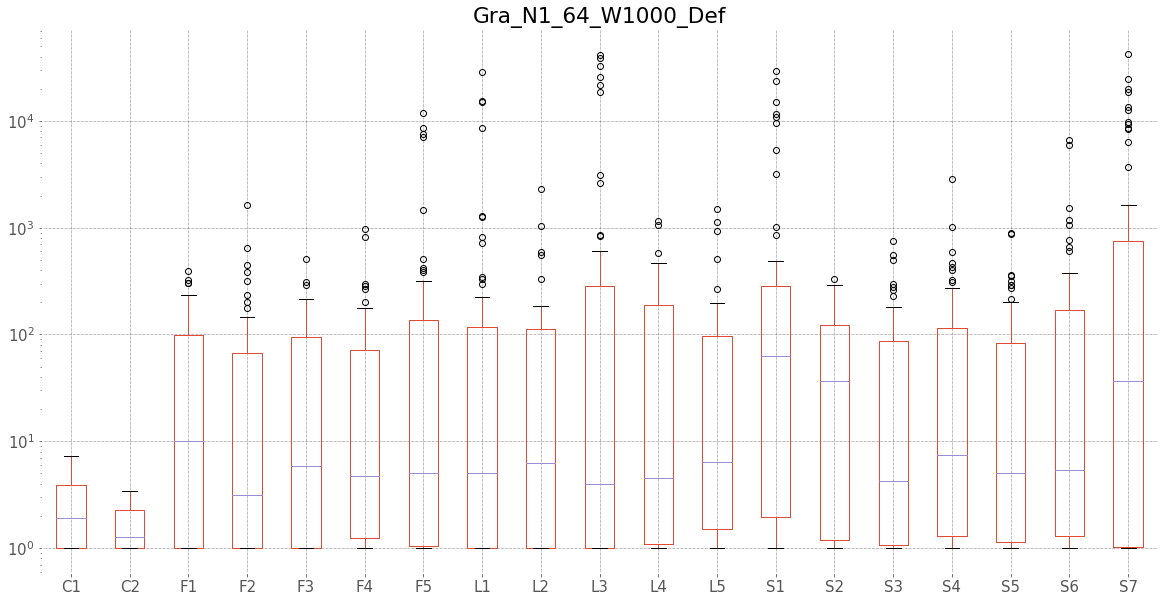

In [84]:
tup = tuple_list[1]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)

In [85]:
tup = tuple_list[2]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
#offset_df = generate_offset_report(tup,None)
#offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
#offset_df_templates = offset_df.pivot_table(values='speedup', columns='speedup', index=offset_df.index)
#offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup))

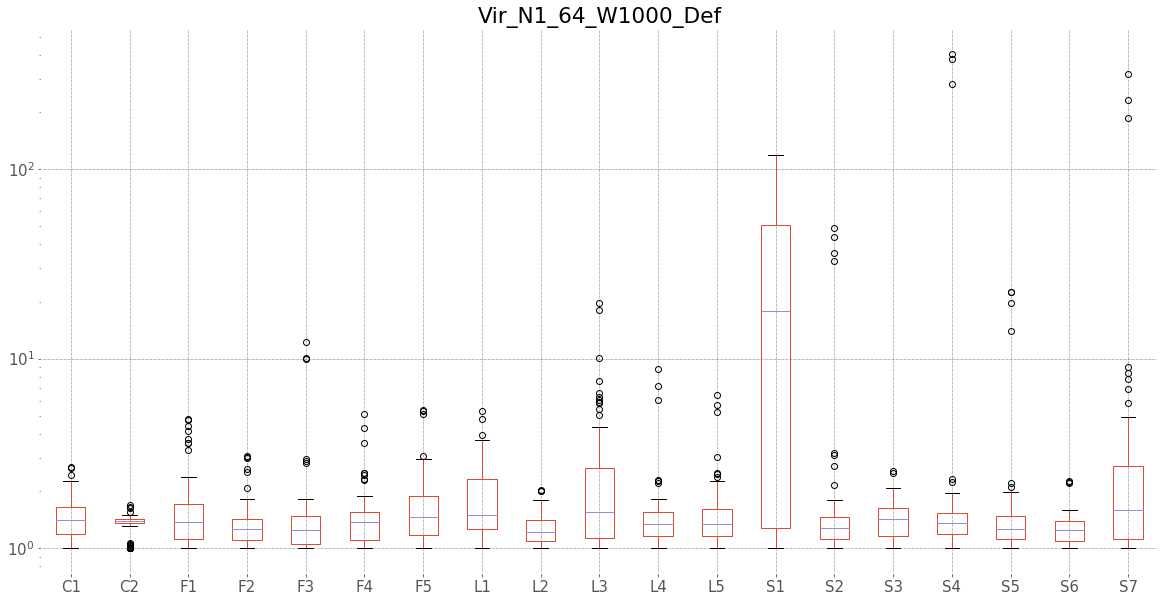

In [86]:
tup = tuple_list[3]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)

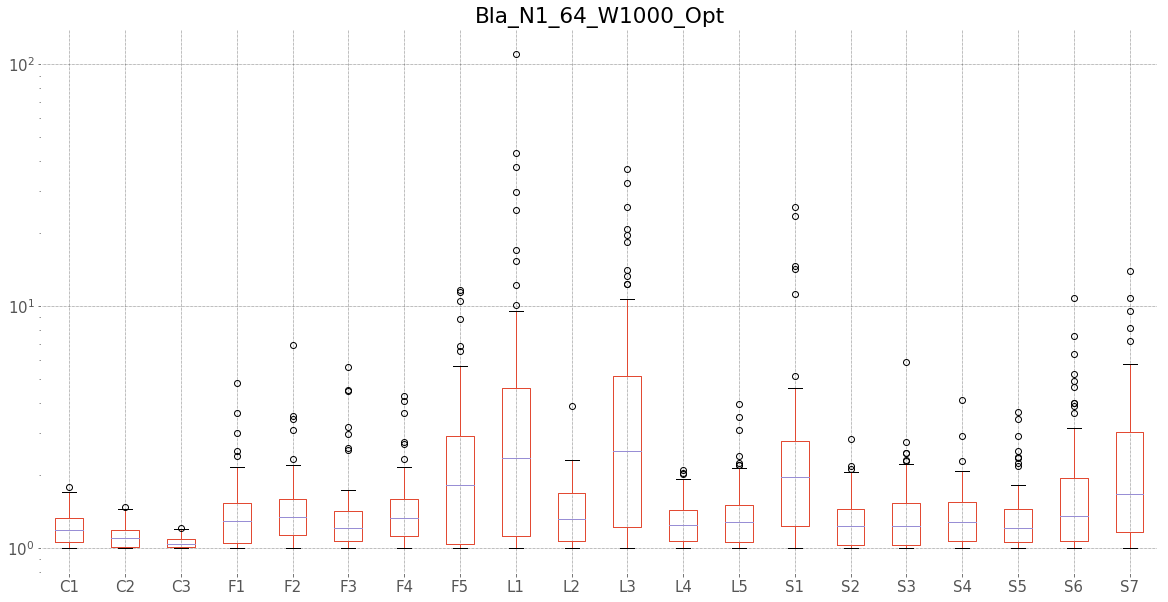

In [87]:
tup = tuple_list[4]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)

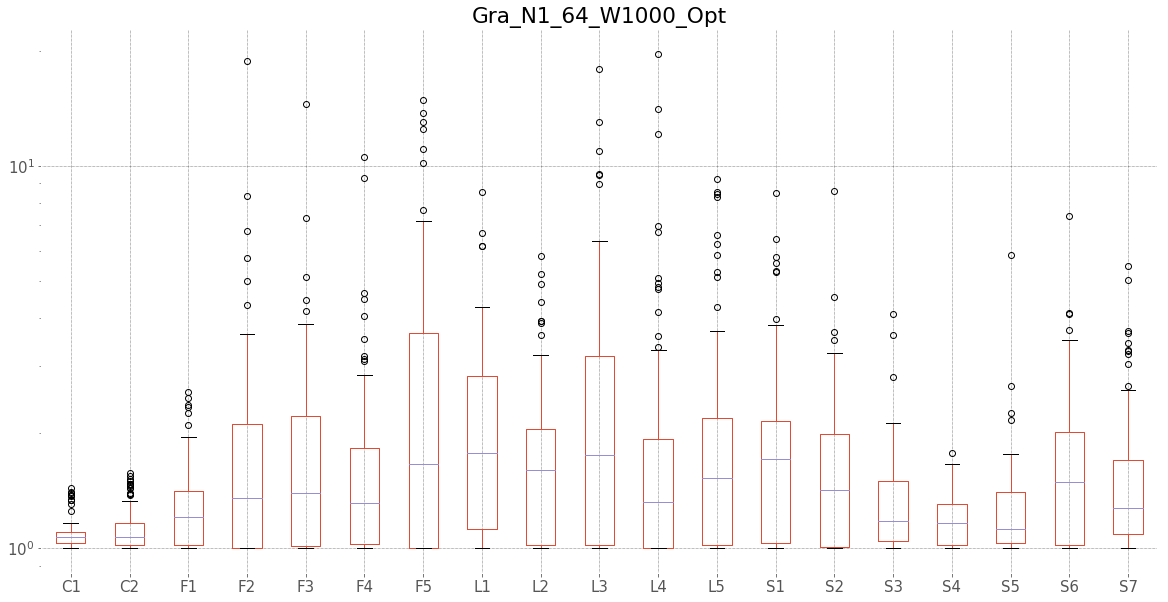

In [88]:
tup = tuple_list[5]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)

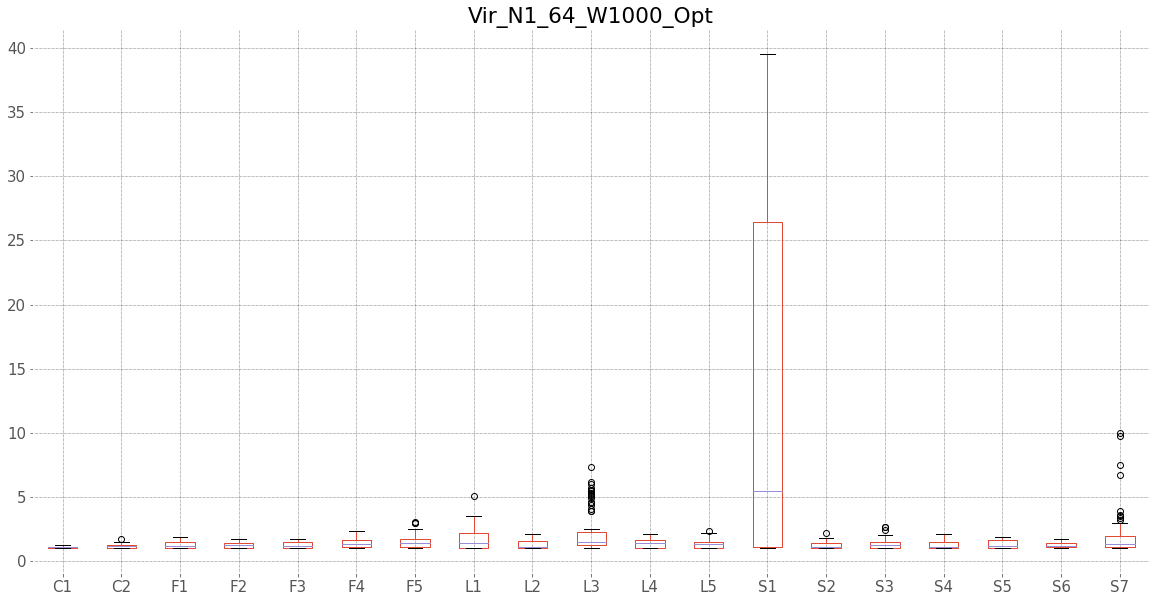

In [89]:
tup = tuple_list[6]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup))

In [90]:
tup = tuple_list[7]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
#offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)

In [91]:
tup = tuple_list[8]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
#offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)

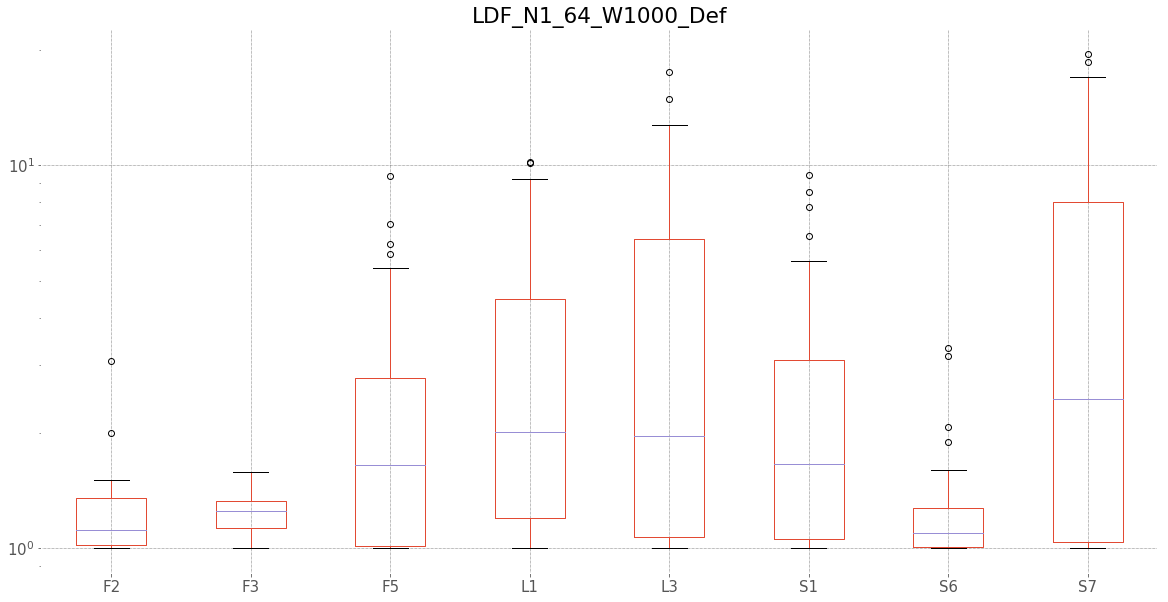

In [92]:
tup = tuple_list[9]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)

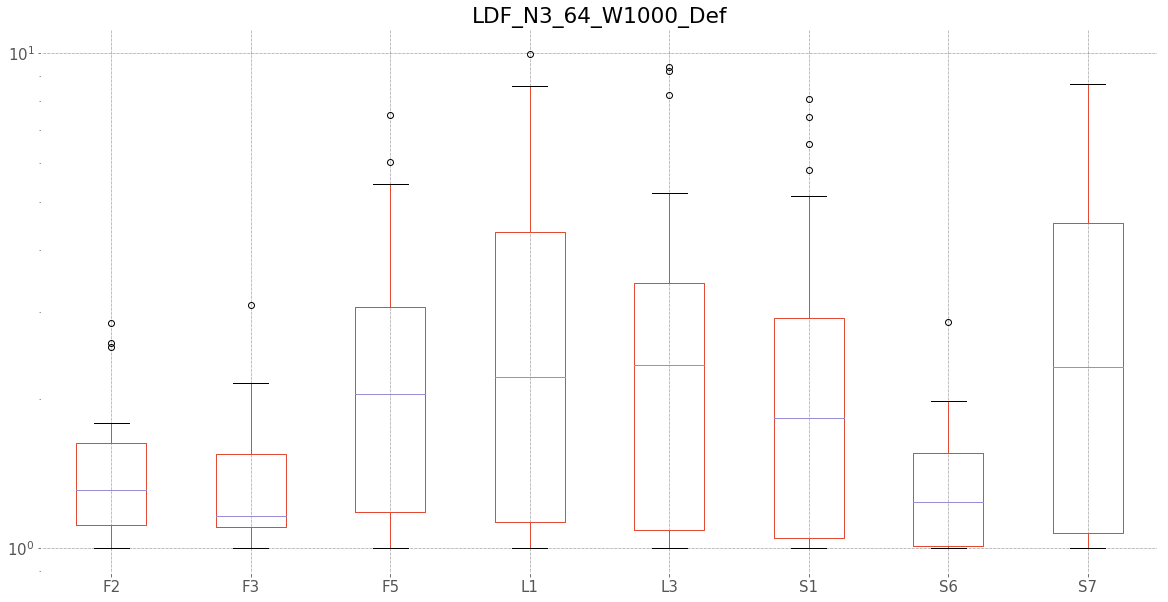

In [93]:
tup = tuple_list[10]
#fig, ax = plt.subplots(2,3, figsize=(20,20))
offset_df = generate_offset_report(tup,None)
offset_df['query_type'] = offset_df['query_name'].apply(lambda l: l[:2])
offset_df_templates = offset_df.pivot_table(values='speedup', columns='query_type', index=offset_df.index)
offset_df_templates.plot(kind='box', figsize=(20,10), title=generateSimulationIDCompact(tup), logy=True)